<h1 align="center">TP 3: Algorithmes de detection de communautés</h1> 
<h1 align="center">LAB 3: Community detection Algorithms</h1> 
</br>
</br>
</br>
<img src="../../images/community.svg" style="display:block;margin-left:auto;margin-right:auto;width:50%;"></img>

In [3]:
!pip install sklearn
!pip install neo4j-driver
!pip install cdlib
!pip install scikit-network

  Using cached neo4j_driver-4.3.4-py3-none-any.whl


In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

import sknetwork as skn
from sklearn.metrics.cluster import normalized_mutual_info_score

%matplotlib inline

# Style pour le Notebook
from IPython.core.display import HTML

def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [5]:
import networkx as nx
from packaging import version
import sys 

print("Python version:", sys.version)
print("networkx version:", nx.__version__)

# assert networkx version is greater or equal to 2.6
assert version.parse(nx.__version__) >= version.parse("2.6")

# assert python version is greater that 3.7
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 7  

# assert sknetwork version is greater or equal to 0.24
assert version.parse(skn.__version__) >= version.parse("0.24")

Python version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]
networkx version: 2.6.3


## (EN)
## Zachary's karate club ([Wikipedia](https://en.wikipedia.org/wiki/Zachary%27s_karate_club#cite_note-Zachary-2))

Zachary's karate club is a social network of a university karate club, described in the paper "An Information Flow Model for Conflict and Fission in Small Groups" by Wayne W. Zachary. The network became a popular example of community structure in networks after its use by Michelle Girvan and Mark Newman in 2002.

A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972 __[Z77]__. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members of the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split.

### References

__[Z77]__
Zachary, W. W. (1977). An Information Flow Model for Conflict and Fission in Small Groups. Journal of Anthropological Research. 33 (4): 452–473.

## (FR)
## Le club de karaté de Zachary ([Wikipedia](https://en.wikipedia.org/wiki/Zachary%27s_karate_club#cite_note-Zachary-2))

Le club de karaté de Zachary est un réseau social d'un club de karaté universitaire, décrit dans l'article «Un modèle de flux d'information pour les conflits et la fission en petits groupes» de Wayne W. Zachary. Le réseau est devenu un exemple populaire de structure communautaire dans les réseaux après son utilisation par Michelle Girvan et Mark Newman en 2002. 

Un réseau social d'un club de karaté universitaire a été étudié par Wayne W. Zachary pendant une période de trois ans de 1970 à 1972 __[Z77]__. Le réseau capture 34 membres d'un club de karaté, documentant les liens entre des paires de membres qui ont interagi en dehors du club. Au cours de l'étude, un conflit est survenu entre l'administrateur «John A» et l'instructeur «M. Hi» (pseudonymes), ce qui a conduit à la scission du club en deux. La moitié des membres ont formé un nouveau club autour de M. Hi; les membres de l'autre partie ont trouvé un nouvel instructeur ou ont abandonné le karaté. Sur la base des données collectées, Zachary a correctement attribué tous les membres du club sauf un aux groupes qu'ils ont effectivement rejoints après la scission.

### Références

__[Z77]__
Zachary, W. W. (1977). An Information Flow Model for Conflict and Fission in Small Groups. Journal of Anthropological Research. 33 (4): 452–473.

In [6]:
from networkx.drawing.layout import spring_layout

def plot_graph(G, node_color, colormap="RdBu_r", ax=None):
    dpi = 300
    h,w = 2480,3508

    pos = spring_layout(G, weight="weight")
    #pos = spring_layout(G)


    fig = plt.figure(figsize=(w/dpi,h/dpi),dpi=dpi)
    ax = plt.gca()

    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=300,
        edgecolors="white",
        node_color=node_color,
        cmap=colormap,
    )

    nx.draw_networkx_labels(G, pos, font_size=7, font_color="white")

    ax.margins(0.20)
    plt.axis("off")
    plt.show()

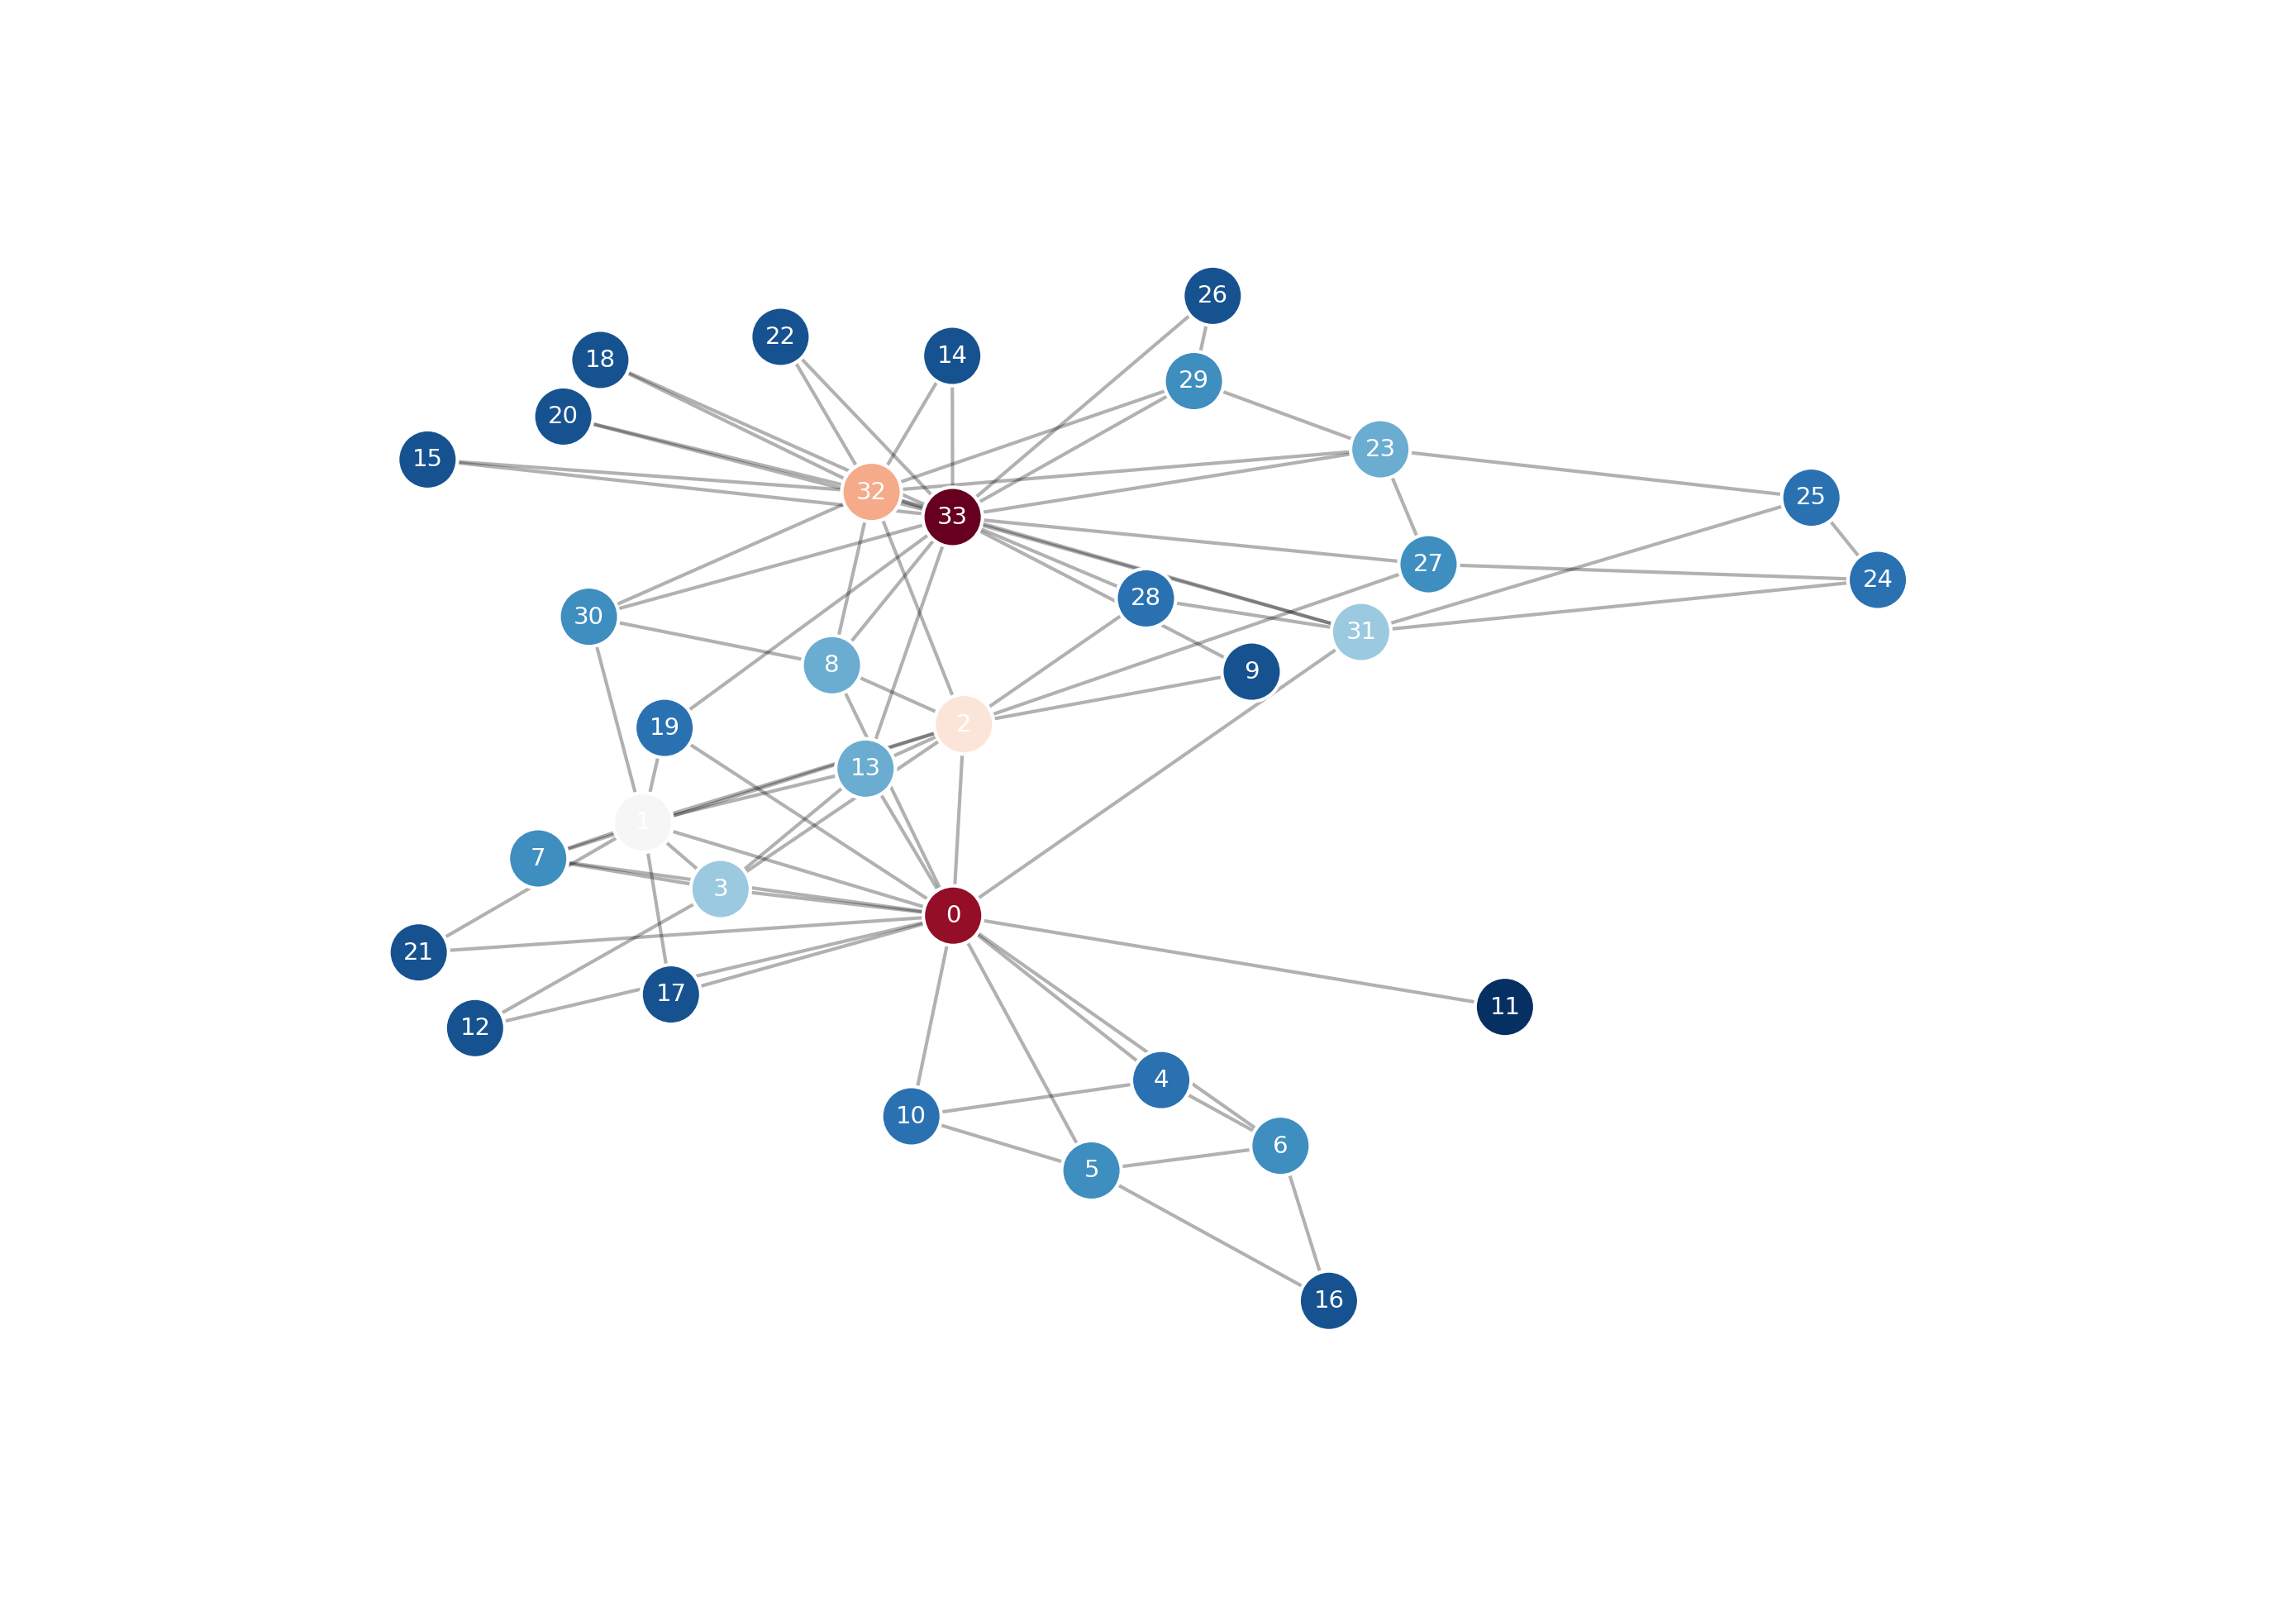

In [7]:
G = nx.karate_club_graph()

node_degree = list(dict(G.degree()).values())
node_color = (np.array(node_degree) - np.mean(node_degree))/np.std(node_degree)

plot_graph(G, node_color=node_color)

## Exercice 1: Label propagation algorithm (LPA)

### (EN)

The Label Propagation algorithm (LPA) is a fast algorithm for finding communities in a graph. It detects these communities using network structure alone as its guide, and doesn’t require a predefined objective function or prior information about the communities.

LPA is a relatively new algorithm, and was only proposed by *Raghavan et al* in 2007, in __[RAK07]__. It works by propagating labels throughout the network and forming communities based on this process of label propagation.

The intuition behind the algorithm is that a single label can quickly become dominant in a densely connected group of nodes, but will have trouble crossing a sparsely connected region. Labels will get trapped inside a densely connected group of nodes, and those nodes that end up with the same label when the algorithms finish can be considered part of the same community.

The algorithm works as follows:

1. Every node is initialized with a unique community label (an identifier).
2. These labels propagate through the network.
3. At every iteration of propagation, each node updates its label to the one that the maximum numbers of its neighbors belong to. Ties are broken uniformly and randomly.
4. LPA reaches convergence when each node has the majority label of its neighbors.
5. LPA stops if either convergence or the user-defined maximum number of iterations is achieved.

As labels propagate, densely connected groups of nodes quickly reach a consensus on a unique label. At the end of the propagation only a few labels will remain - most will have disappeared. Nodes that have the same community label at convergence are said to belong to the same community.

### 1.1) Implement the Label propagation algorithm (LPA)

* __Step 1__: give a unique label to each node in the network
* __Step 2__: Arrange the nodes in the network in a random order, please use the Fisher-Yates algorithm __[FY]__ to shuffle the nodeID in random order
* __Step 3__: for each node in the network (in this random order) set its label to a label occurring with the highest frequency  among its neighbors (break ties uniformly)
* __Step 4__ : go to 2 as long as there exists a node with a label that does not have the highest frequency among its neighbors.

### References

__[RAK07]__
Raghavan, U. N., Albert, R., & Kumara, S. (2007). Near linear time algorithm to detect community structures in large-scale networks. Physical Review E - Statistical, Nonlinear, and Soft Matter Physics. [10.1103/PhysRevE.76.036106](https://doi.org/10.1103/PhysRevE.76.036106)

__[FY]__ 
[Fisher-Yates shuffle](https://en.wikipedia.org/wiki/Fisher-Yates_shuffle)

### (FR)

L'algorithme de propagation d'étiquette (Label Propagation Algorithm or LPA) est un algorithme rapide pour trouver des communautés dans un graph. Il détecte ces communautés en utilisant uniquement la structure du réseau comme guide et ne nécessite pas de fonction d'objectif prédéfinie ou d'informations préalables sur les communautés.

LPA est un algorithme relativement nouveau, et n'a été proposé que par *Raghavan et al* en 2007, dans __[RAK07]__. Il fonctionne en propageant les étiquettes à travers le réseau et en formant des communautés basées sur ce processus de propagation des étiquettes.

L'intuition derrière l'algorithme est qu'une seule étiquette peut rapidement devenir dominante dans un groupe de nœuds densément connectés, mais aura du mal à traverser une région faiblement connectée. Les étiquettes seront piégées dans un groupe de nœuds densément connectés, et les nœuds qui se retrouveront avec la même étiquette une fois les algorithmes terminés peuvent être considérés comme faisant partie de la même communauté.

L'algorithme fonctionne comme suit:
1. Chaque noeud est initialisé avec une étiquette de communauté unique (un identifiant).
2. Ces étiquettes se propagent à travers le réseau, on sélectionne.
3. À chaque itération de propagation, chaque noeud met à jour son étiquette avec celle à laquelle appartient le nombre maximum de ses voisins. Les égalités sont rompues de manière uniforme et aléatoire.
4. LPA atteint la convergence lorsque chaque noeud a l'étiquette majoritaire de ses voisins.
5. LPA s'arrête si la convergence ou le nombre maximal d'itérations défini par l'utilisateur est atteint.

À mesure que les étiquettes se propagent, des groupes de noeuds densément connectés parviennent rapidement à un consensus sur une étiquette unique. À la fin de la propagation, il ne restera que quelques étiquettes - la plupart auront disparu. On dit que les nœuds qui ont le même label de communauté à la convergence appartiennent à la même communauté.

### 1.1) Implémentation de l'algorithme LPA

* __Étape 1__: attribuez une étiquette unique à chaque noeud du réseau
* __Étape 2__: Disposez les noeuds du réseau dans un ordre aléatoire, veuillez utiliser l'algorithme de Fisher-Yates __[FY]__ pour mélanger  l’ID des noeuds. aléatoirement
* __Étape 3__: pour chaque noeud du réseau (dans cet ordre aléatoire), définissez son étiquette sur une étiquette se produisant avec la fréquence la plus élevée parmi ses voisins
* __Étape 4__: passez à 2 tant qu'il existe un nœud avec une étiquette qui n'a pas la fréquence la plus élevée parmi ses voisins. 

### 1.2) afficher le résultat l'algorithme LPA avec le réseau du karaté club

### Références

__[RAK07]__
Raghavan, U. N., Albert, R., & Kumara, S. (2007). Near linear time algorithm to detect community structures in large-scale networks. Physical Review E - Statistical, Nonlinear, and Soft Matter Physics. [10.1103/PhysRevE.76.036106](https://doi.org/10.1103/PhysRevE.76.036106)

__[FY]__ 
[Fisher-Yates shuffle](https://en.wikipedia.org/wiki/Fisher-Yates_shuffle)

In [8]:
def fisher_yates(arr):
    ### BEGIN SOLUTION
    from random import randint

    for i in range(len(arr)):
        j = randint(0, len(arr)-1)
        arr[j],arr[i] = arr[i],arr[j]
        
    return arr
    ### END SOLUTION

In [31]:
def lpa(G, max_iter=100):
    ### BEGIN SOLUTION
    from random import choice
    from collections import Counter
    
    N = len(G)
    labels = {n: i for i, n in enumerate(G)}
    cont = True
    n_iter = 0
    
    while cont and n_iter < max_iter:
        cont = False
        nodes = fisher_yates(list(G.nodes()))
        n_iter += 1
 
        for v in nodes:
            
            if not list(G.neighbors(v)):
                # Nodes with no neighbors are themselves a community and are labeled
                # accordingly, hence the immediate if statement.
                continue

            # Get label frequencies. Depending on the order they are processed
            # in some nodes with be in t and others in t-1, making the
            # algorithm asynchronous.
            label_freq = Counter()
            for u in G.neighbors(v):
                label_freq.update({labels[u]:1})

            # Choose the label with the highest frecuency. If more than 1 label
            # has the highest frecuency choose one randomly.
            max_freq = max(label_freq.values())

            best_labels = []
            for label, freq in label_freq.items():
                 if freq == max_freq:
                    best_labels.append(label)

            # Continue until all nodes have a majority label
            if labels[v] not in best_labels:
                labels[v] = choice(best_labels)
                cont = True
        
    return labels
    ### END SOLUTION

In [32]:
community_dict = lpa(G)

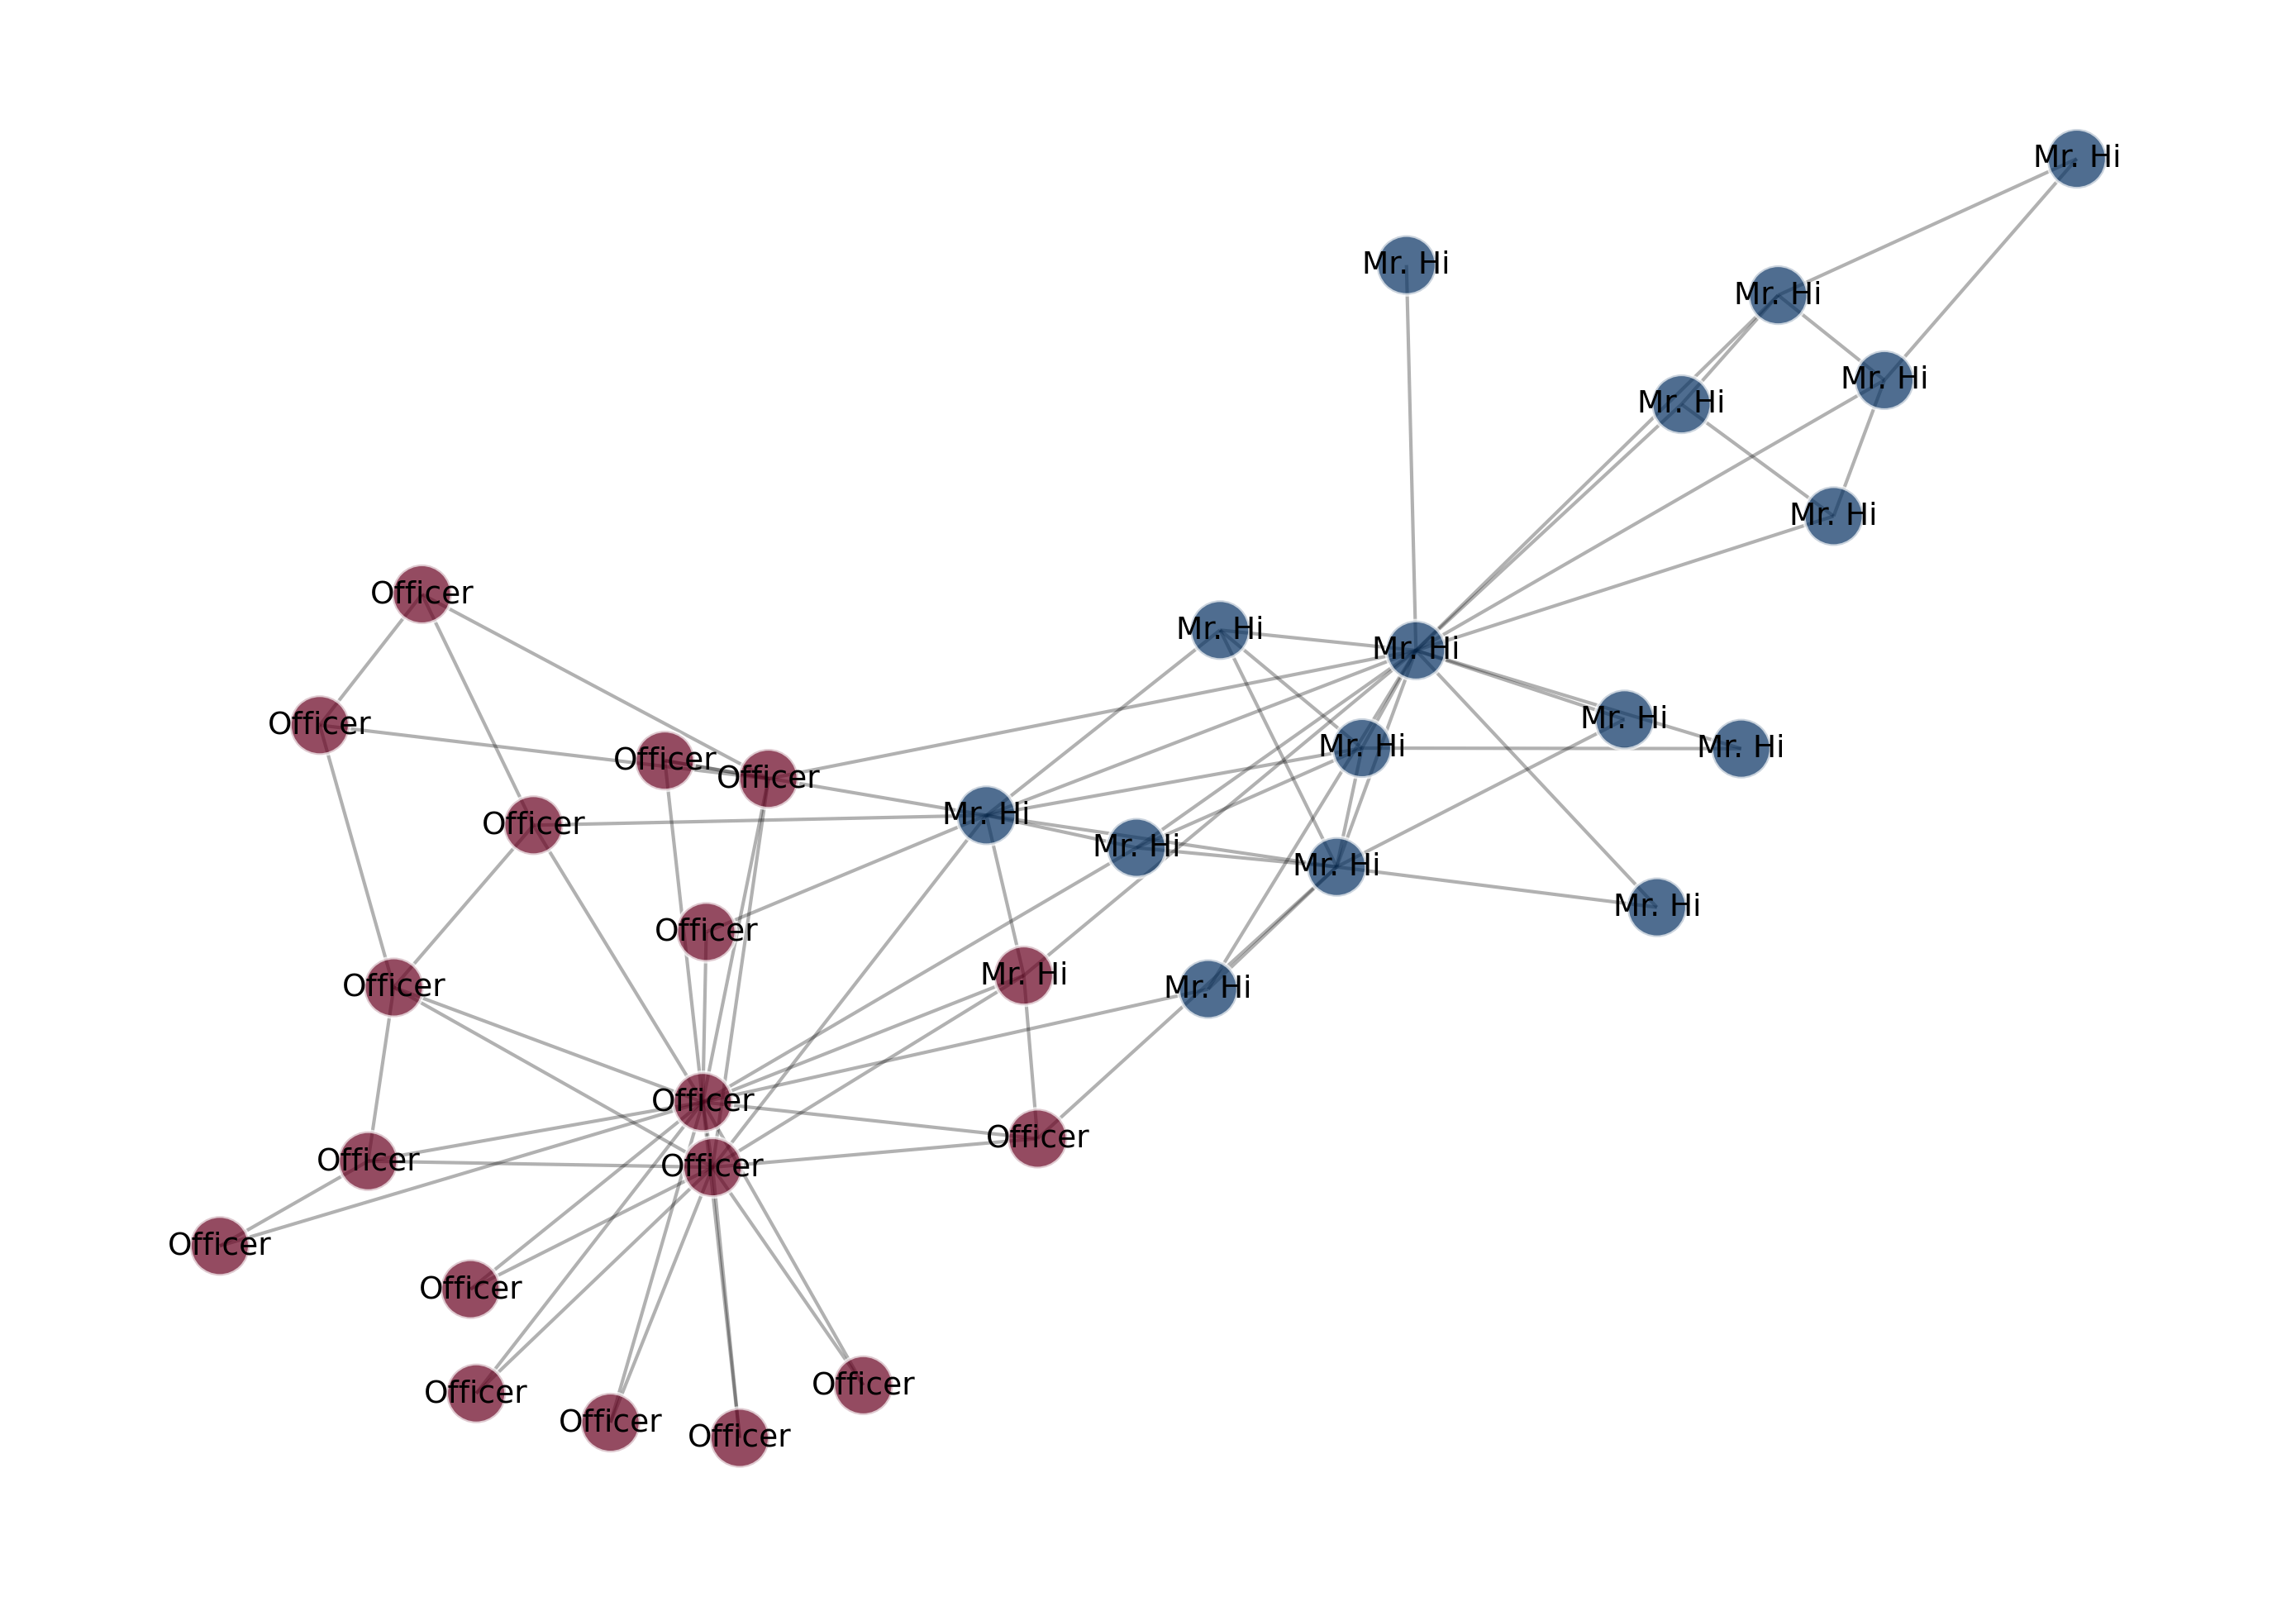

In [33]:
dpi = 300
h,w = 2480,3508
fig = plt.figure(figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.gca()


pos = spring_layout(G)

nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_nodes(
        G,
        pos,
        node_color=[community_dict[node_id] for node_id in list(G)],
        edgecolors="white",
        alpha=0.7,
        cmap="RdBu_r"
)
nx.draw_networkx_labels(
                        G, 
                        pos, 
                        labels={ n_id:G.nodes[n_id]["club"] for n_id in G.nodes()}, 
                        font_size=9, 
                        font_color="black");
plt.axis("off")
plt.show()

### (EN)
### 1.3) Discuss the results obtained by the LPA algorithm on the "Zachary's karate club"

Your Answer ?

### (FR)
### 1.3) Discuter les resultats obtenue par l'algorithme LPA sur le graph du "Karaté club de Zachary"

Your Answer ?

## (FR)
## Exercice 2: Validation d'un algorithme de detection de communautés
En s'inspirant de __[GIR02]__ nous allons construirte un benchmark pour les algorithmes de détection de communautés. Le modèle de bloc stochastique est un modèle génératif pour les graphes aléatoires. Ce modèle tend à produire des graphes contenant des communautés (des sous-ensembles caractérisés par le fait d'être connectés les uns aux autres avec des densités d'arêtes particulières). Par exemple, les lisières peuvent être plus fréquentes au sein des communautés qu'entre les communautés. Le modèle de bloc stochastique est important dans les statistiques, l'apprentissage automatique et la science des réseaux, où il sert de référence.

Implémentez un algorithme pour générer le graphique aléatoire suivant.

- Le graphe comporte 400 noeuds répartis en 4 clusters de taille 100.
- Chaque paire de noeuds dans le même cluster est connectée avec une probabilité $p$.
- Chaque paire de noeuds dans différents clusters est connectée avec une probabilité $q < p$. Afficher les graphes obtenus pour différentes valeurs de $p$ et $q$ à l'aide d'un logiciel de votre choix ([Networkx](https://networkx.github.io/documentation/stable/reference/drawing)). Quelle est l'effet du rapport $\frac{p}{q}$ sur la structure des communautés ?

__[GIR02]__ M. Girvan, M. E. J. Newman, Community structure in social and biological networks, In Proc. of the National Academy of Sciences Jun 2002, 99 (12) 7821-7826. [(HTML)](https://www.pnas.org/content/99/12/7821)

## (EN)
## Exercice 2: Validation d'un algorithme de detection de communautés

Inspired by the work of __ [GIR02] __ we will build a benchmark for community detection algorithms. The stochastic block model is a generative model for random graphs. This model tends to produce graphs containing communities, subsets characterized by being connected with one another with particular edge densities. For example, edges may be more common within communities than between communities. The stochastic block model is important in statistics, machine learning, and network science, where it serves as a useful benchmark for the task of recovering community structure in graph data.

Implement an algorithm to generate the following random graph.
- The graph has 400 nodes partitioned into 4 clusters of size 100.
- Each pair of nodes in the same cluster is connected with a probability $p$.
- Each pair of nodes in different clusters is connected with a probability $q < p$.
Draw the obtained graphs for various values of $p$ and $q$ using a software of your choice. For instance: [Networkx](https://networkx.github.io/documentation/stable/reference/drawing). 
What is the effect of increasing or decreasing $\frac{p}{q}$ on the community structure?


__[GIR02]__ M. Girvan, M. E. J. Newman, Community structure in social and biological networks, In Proc. of the National Academy of Sciences Jun 2002, 99 (12) 7821-7826. [(HTML)](https://www.pnas.org/content/99/12/7821)

In [8]:
def stochastic_block(n, n_community, p, q):
    ### BEGIN SOLUTION
    from random import random
    
    assert(n % 2 == 0)
    assert(p > q)

    block_size = (n/n_community) - 1

    labels = {}
    G = nx.empty_graph(n)
    
    community_cpt = 1
    cpt = 0

    ## compute labels
    for v in range(n):
        cpt += 1
        labels[v] = community_cpt

        if cpt > block_size:
            cpt = 0
            community_cpt += 1

    ## build random graph labels
    for v in G.nodes():
        for u in range(v+1, len(G)):
            if labels[u] == labels[v]:
                if random() < p:
                    G.add_edge(u, v, weight=1)
            else:
                if random() < q:
                    G.add_edge(u, v, weight=1)
                    
    return G,list(labels.values())
    ### END SOLUTION

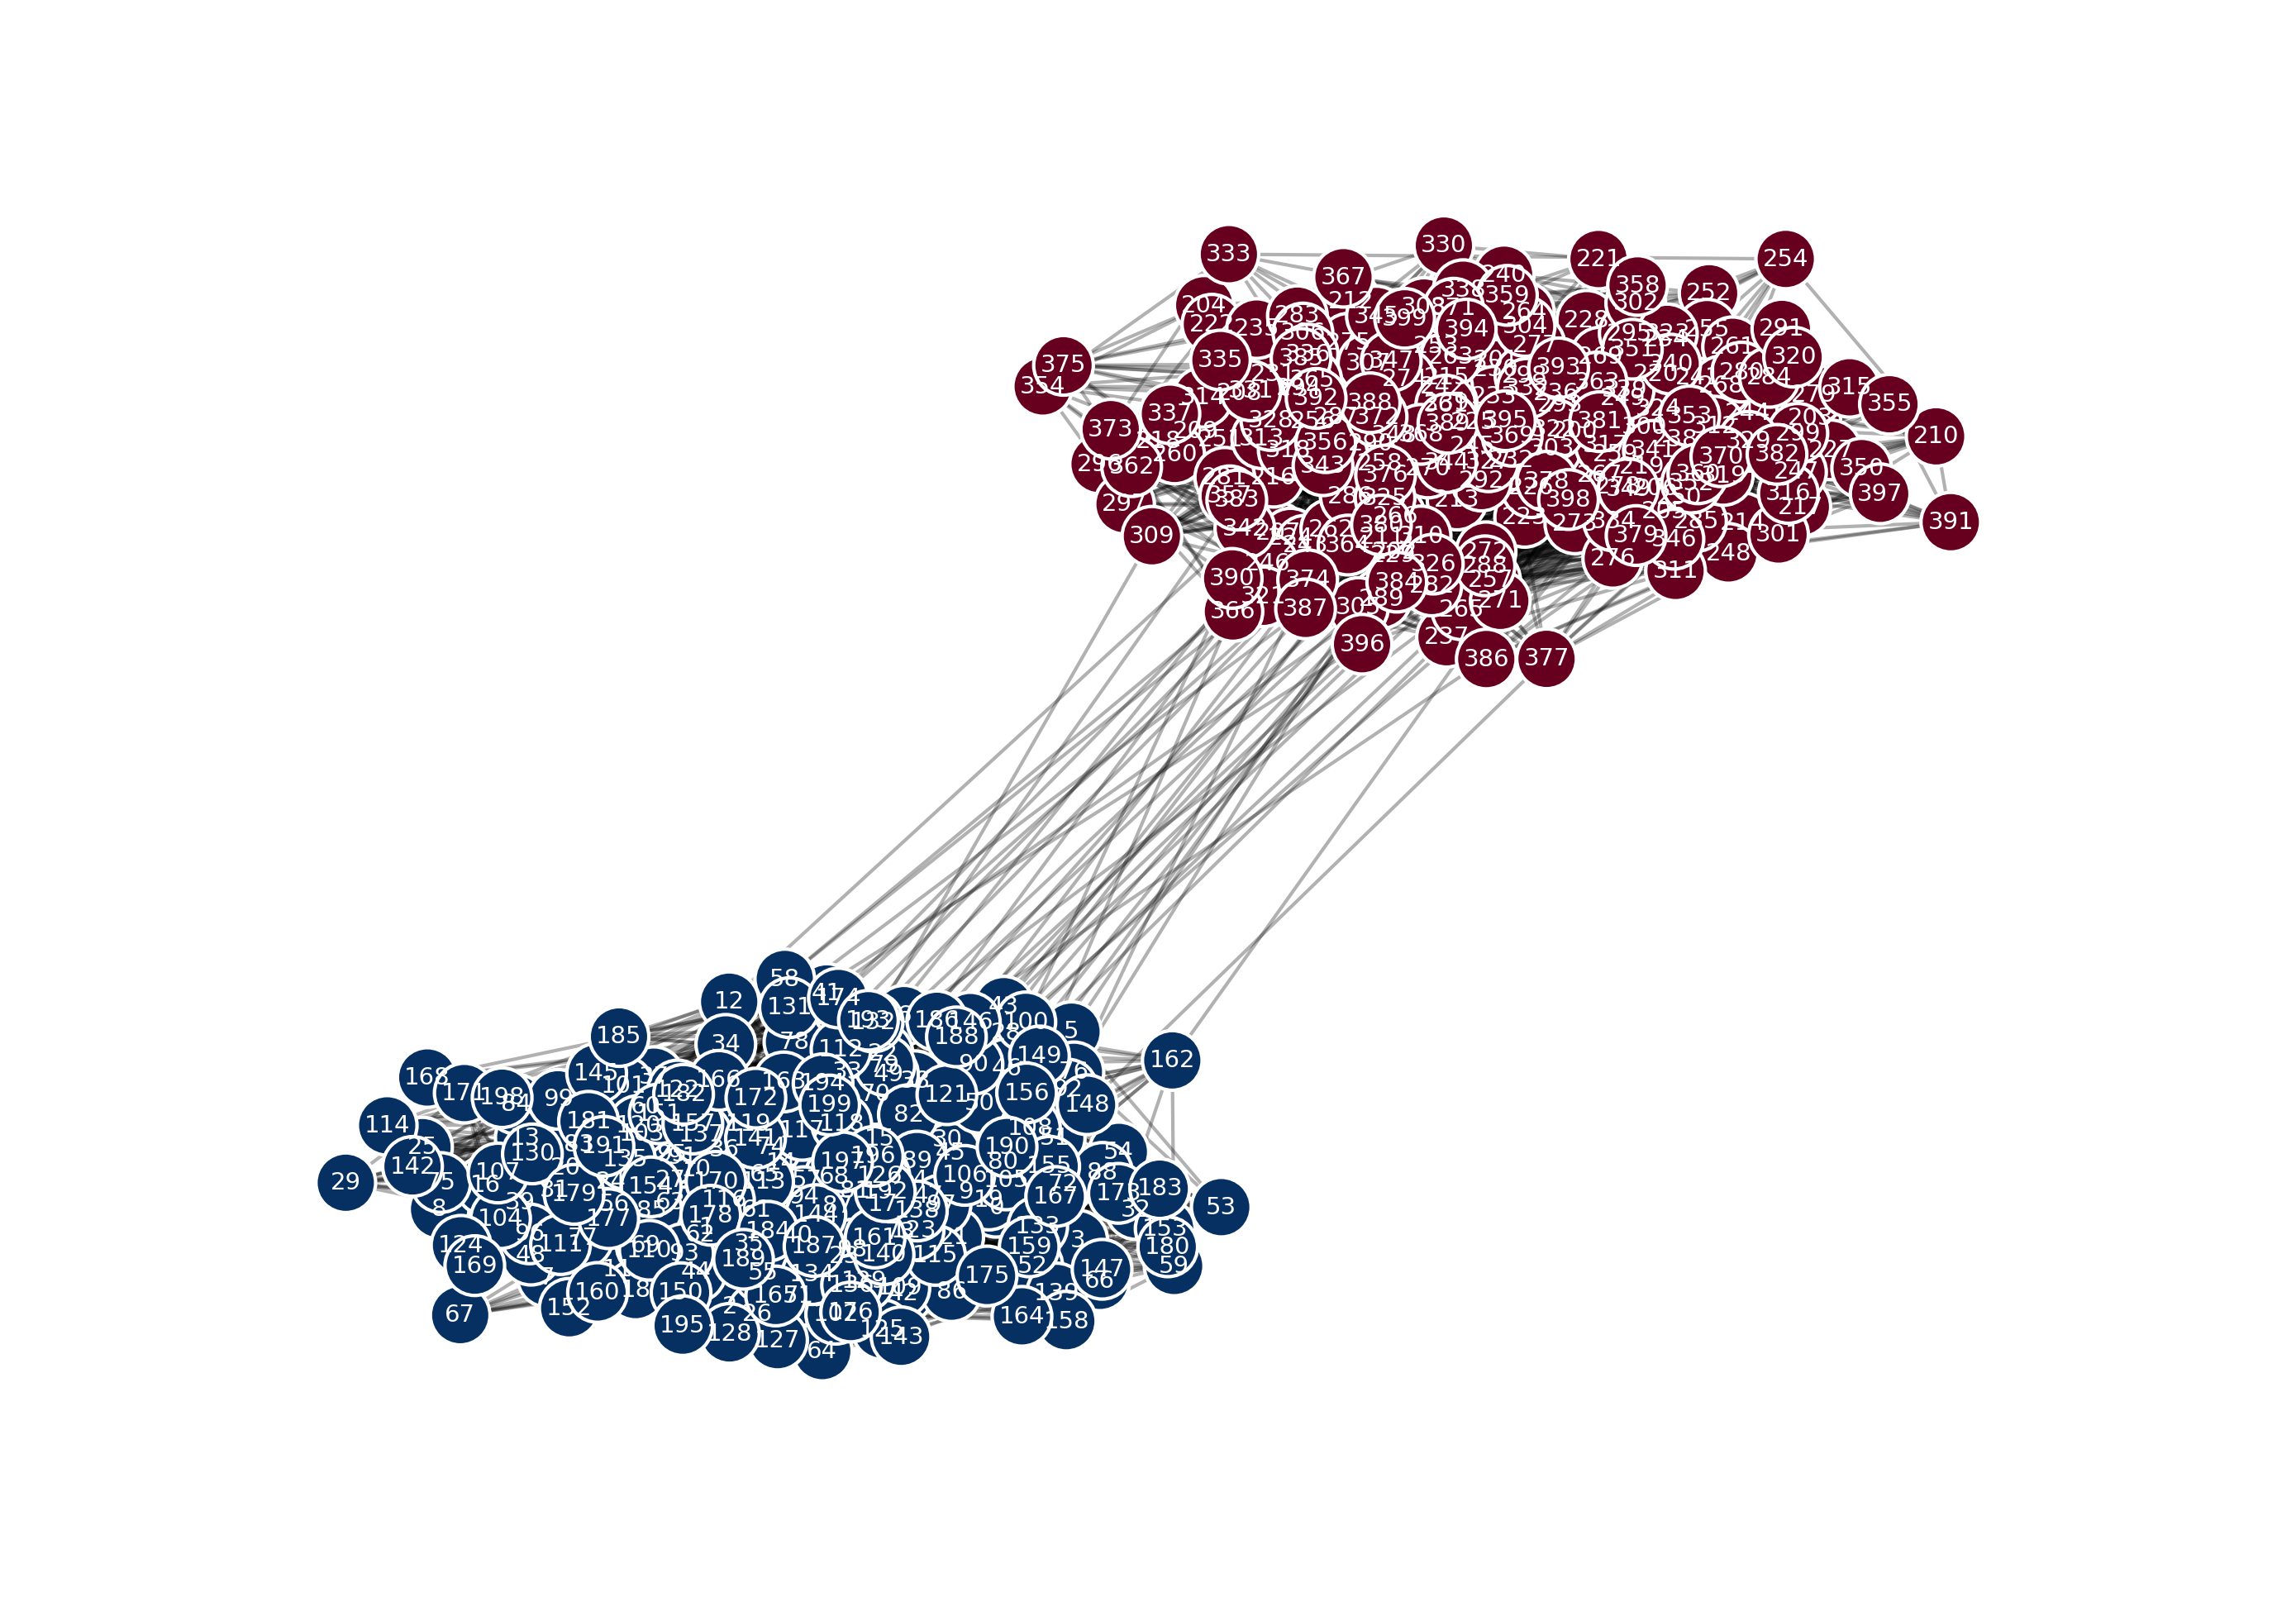

<Figure size 432x288 with 0 Axes>

In [9]:
g1, Ycommunity_true = stochastic_block(400, n_community=2, p=0.1, q=0.001)
plot_graph(g1, node_color=Ycommunity_true)
plt.tight_layout()
plt.show()

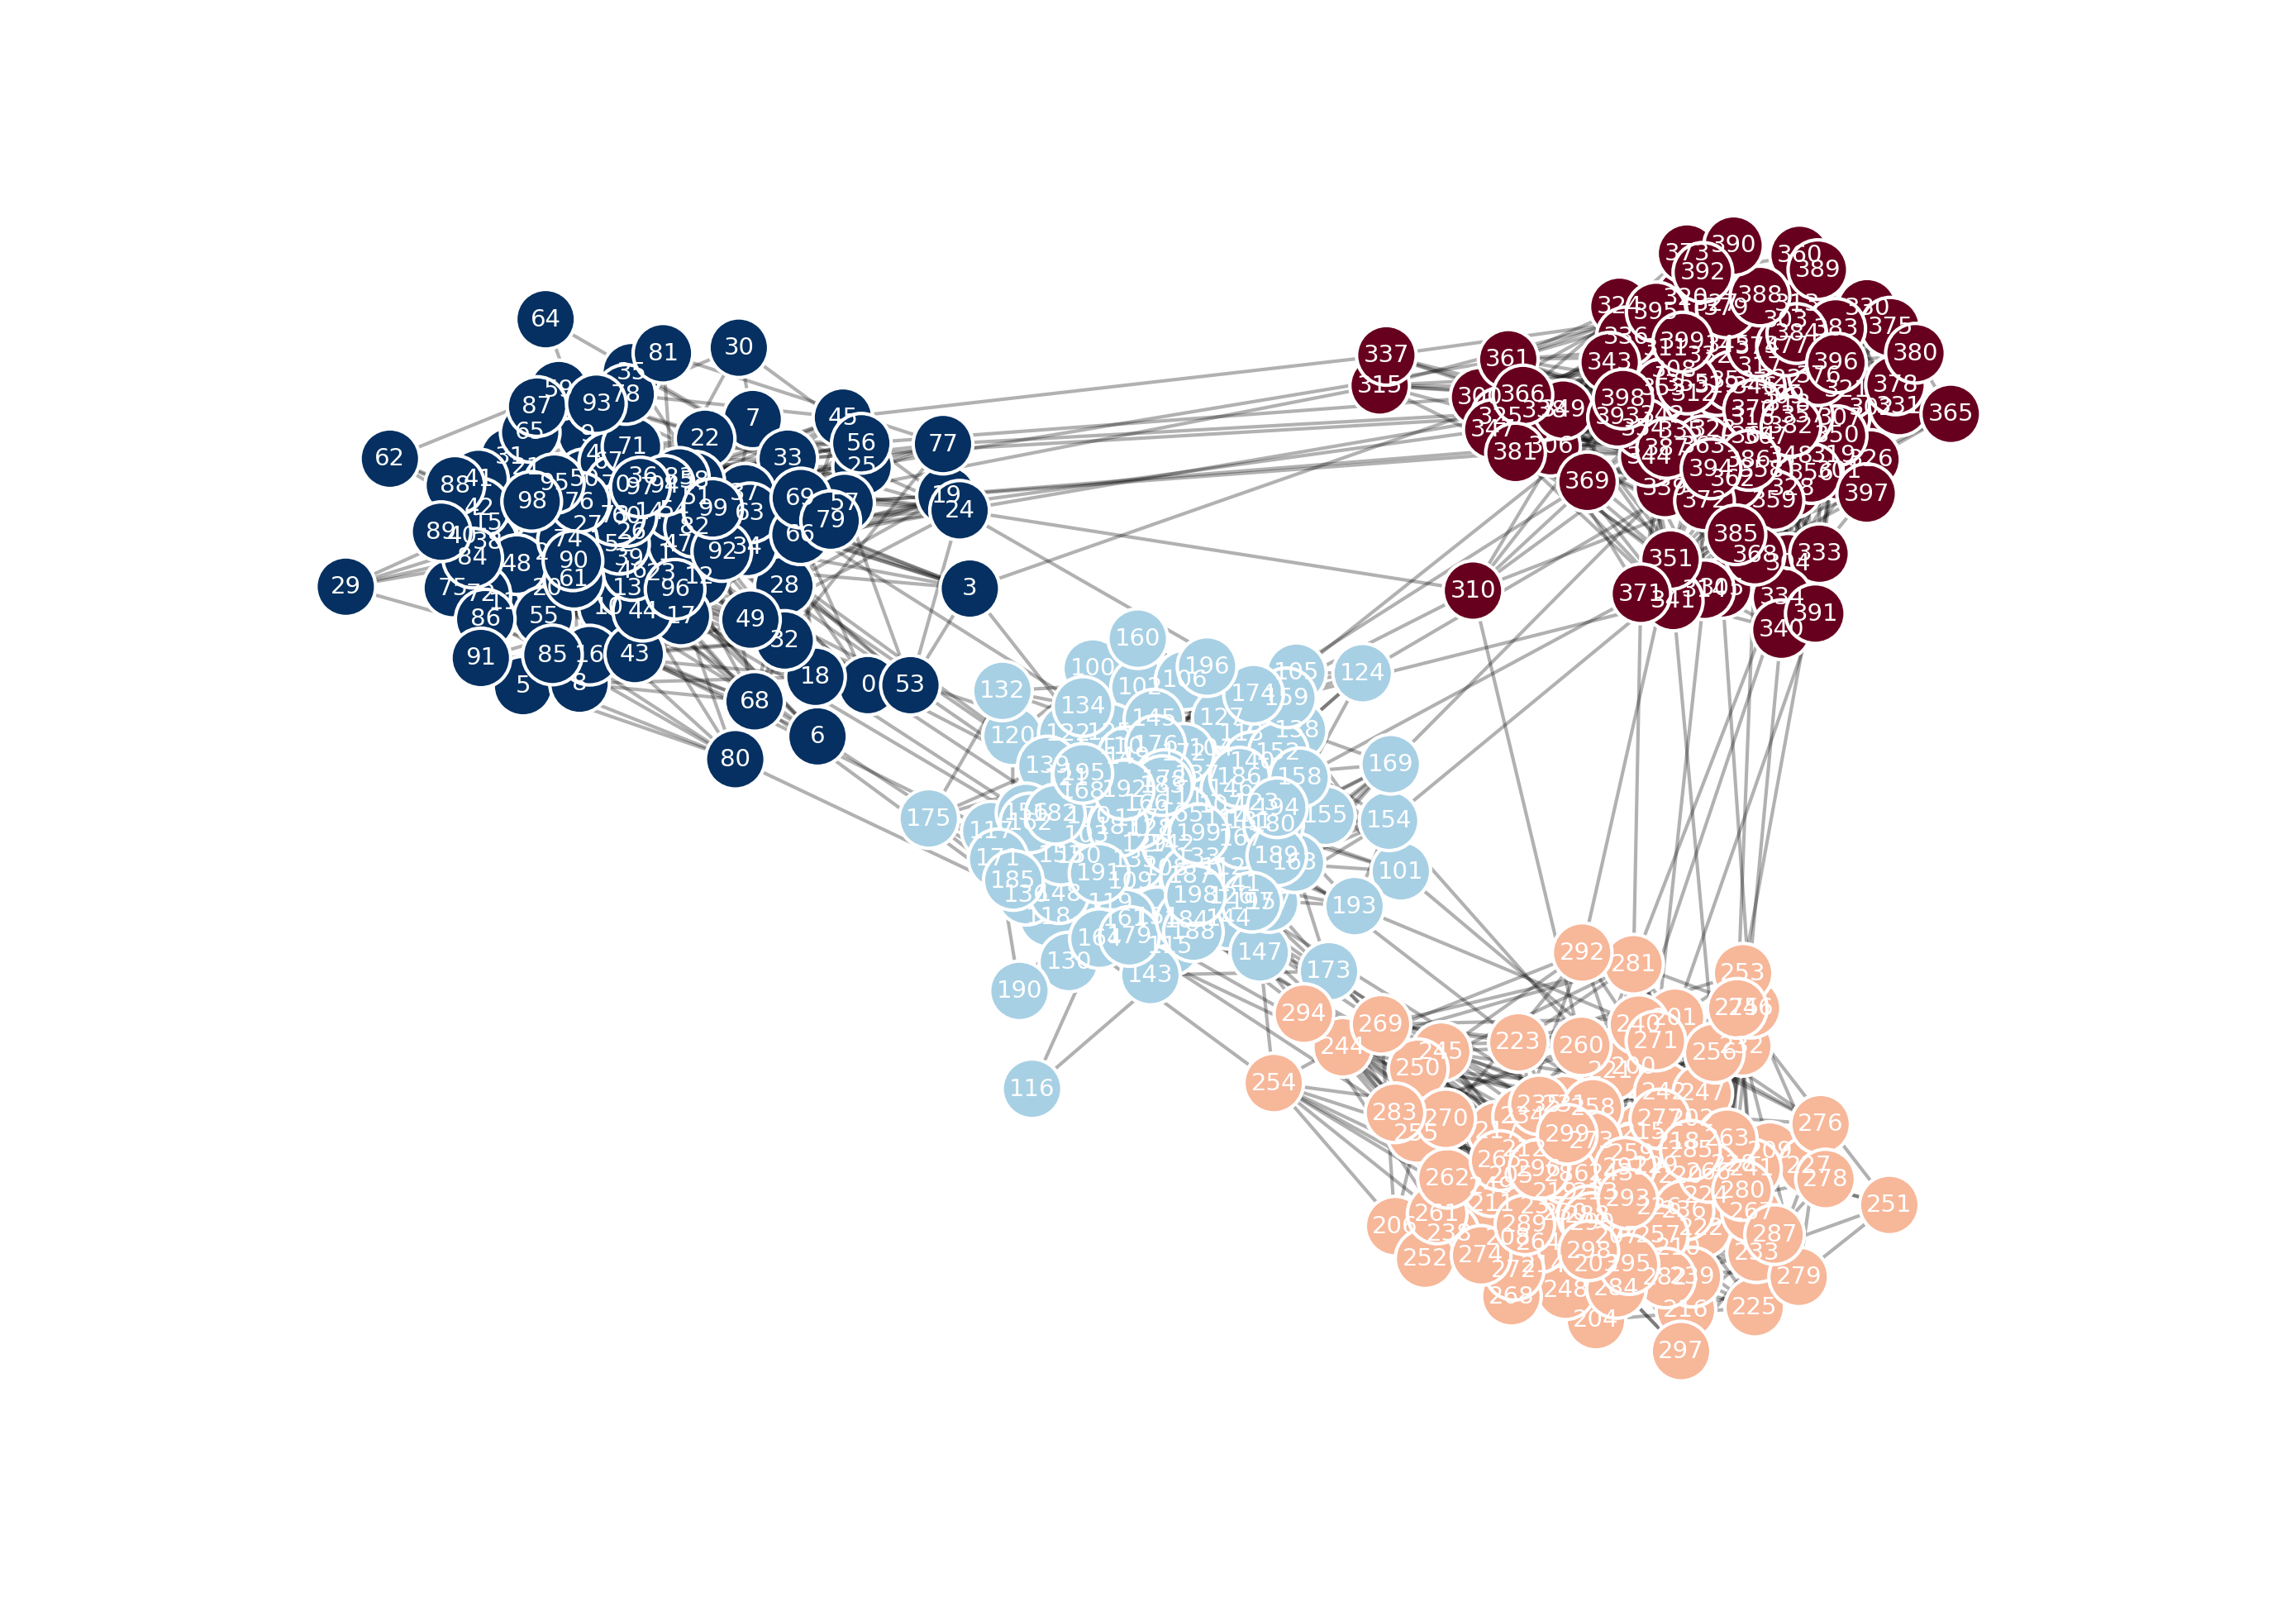

<Figure size 432x288 with 0 Axes>

In [10]:
g2, Ycommunity_true = stochastic_block(400, n_community=4, p=0.1, q=0.001)
plot_graph(g2, node_color=Ycommunity_true)

plt.tight_layout()
plt.show()

In [12]:
n_simulation = 30
p = 0.1
result = []
for n_community in [2, 4, 6, 8]:
    for q in np.linspace(0.001, 0.03, 20):
        mmi = []
        for _ in range(n_simulation):
            g, Ycommunity = stochastic_block(400, n_community=n_community, p=p, q=q)        
            Ycommunity_dict = lpa(g)
            Ycommunity_hat = list(Ycommunity_dict.values())
            mmi.append(normalized_mutual_info_score(Ycommunity, Ycommunity_hat))
        result.append((n_community, q, np.mean(mmi)))

## Plots the results 

In [13]:
df = pd.DataFrame(result, columns=["n_community", "q", "mmi"])

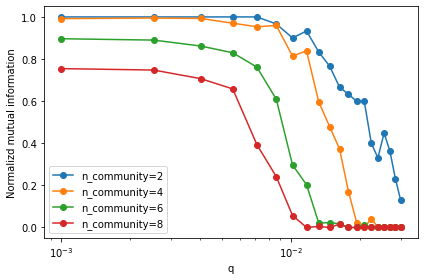

In [14]:
fig, ax = plt.subplots()
ax.semilogx(df[df.n_community == 2].q.values, df[df.n_community == 2].mmi.values, "o-", label="n_community=2")
ax.semilogx(df[df.n_community == 4].q.values, df[df.n_community == 4].mmi.values, "o-", label="n_community=4")
ax.semilogx(df[df.n_community == 6].q.values, df[df.n_community == 6].mmi.values, "o-", label="n_community=6")
ax.semilogx(df[df.n_community == 8].q.values, df[df.n_community == 8].mmi.values, "o-", label="n_community=8")

ax.set_xlabel(r"q")
ax.set_ylabel("Normalizd mutual information")
ax.legend()
plt.tight_layout()
plt.show()

# (EN)
# Exercice 3: Implementation of the Newman/Girvan community detection algorithm


The algorithm's described in __[NEW04]__ steps for community detection are summarized below

- The betweenness of all existing edges in the network is calculated first.
- The edge(s) with the highest betweenness are removed.
- The betweenness of all edges affected by the removal is recalculated.
- Steps 2 and 3 are repeated until no edges remain.

__[NEW04]__  Newman and Girvan, Finding and evaluating community structure in networks, Physical review E, 2004. [(arXiv)](https://arxiv.org/abs/cond-mat/0308217)


# (FR)
# Exercice 3 : Implémentation de l'algorithme de détection de communautés de Newman/Girvan

Les algorithmes décrits dans les étapes suivantes __[NEW04]__ résumés ci-dessous

- On calcule la betweenness de toutes les arêtes existantes dans le réseau.
- le lien avec la betweenness la plus élevée est supprimé du graph.
- On recalcule la betweenness de toutes les arêtes restante dans le réseau.
- Les étapes 2 et 3 sont répétées jusqu'à ce que le nombre de communautés désirer soit atteint.

__[NEW04]__  Newman and Girvan, Finding and evaluating community structure in networks, Physical review E, 2004. [(arXiv)](https://arxiv.org/abs/cond-mat/0308217)

In [85]:
def newman_girvan(G, n_community=2):
    ### BEGIN SOLUTION
    max_iter = nx.number_of_edges(G)
    for _ in range(max_iter):
        edge_bw = nx.edge_betweenness_centrality(G)
        # get the egdes with the bigest betweeness
        edge_to_remove = sorted(edge_bw.items(), key=lambda item: item[1])[-1][0]
        G.remove_edge(edge_to_remove[0], edge_to_remove[1])
        if nx.number_connected_components(G) >= n_community:
            S = [list(G.subgraph(c).copy()) for c in nx.connected_components(G)]
            return S
    ### END SOLUTION

In [106]:
G = nx.karate_club_graph()
nodes = newman_girvan(G)

# save the community assignment in the graph structure
G = nx.karate_club_graph()
for communityId, community in enumerate(nodes):
    for nodeId in community:
        G.nodes[nodeId]["community"] = communityId

## 3.2 Plot the community structure of the Karate club social graph according the Newman/Girvan algorithm

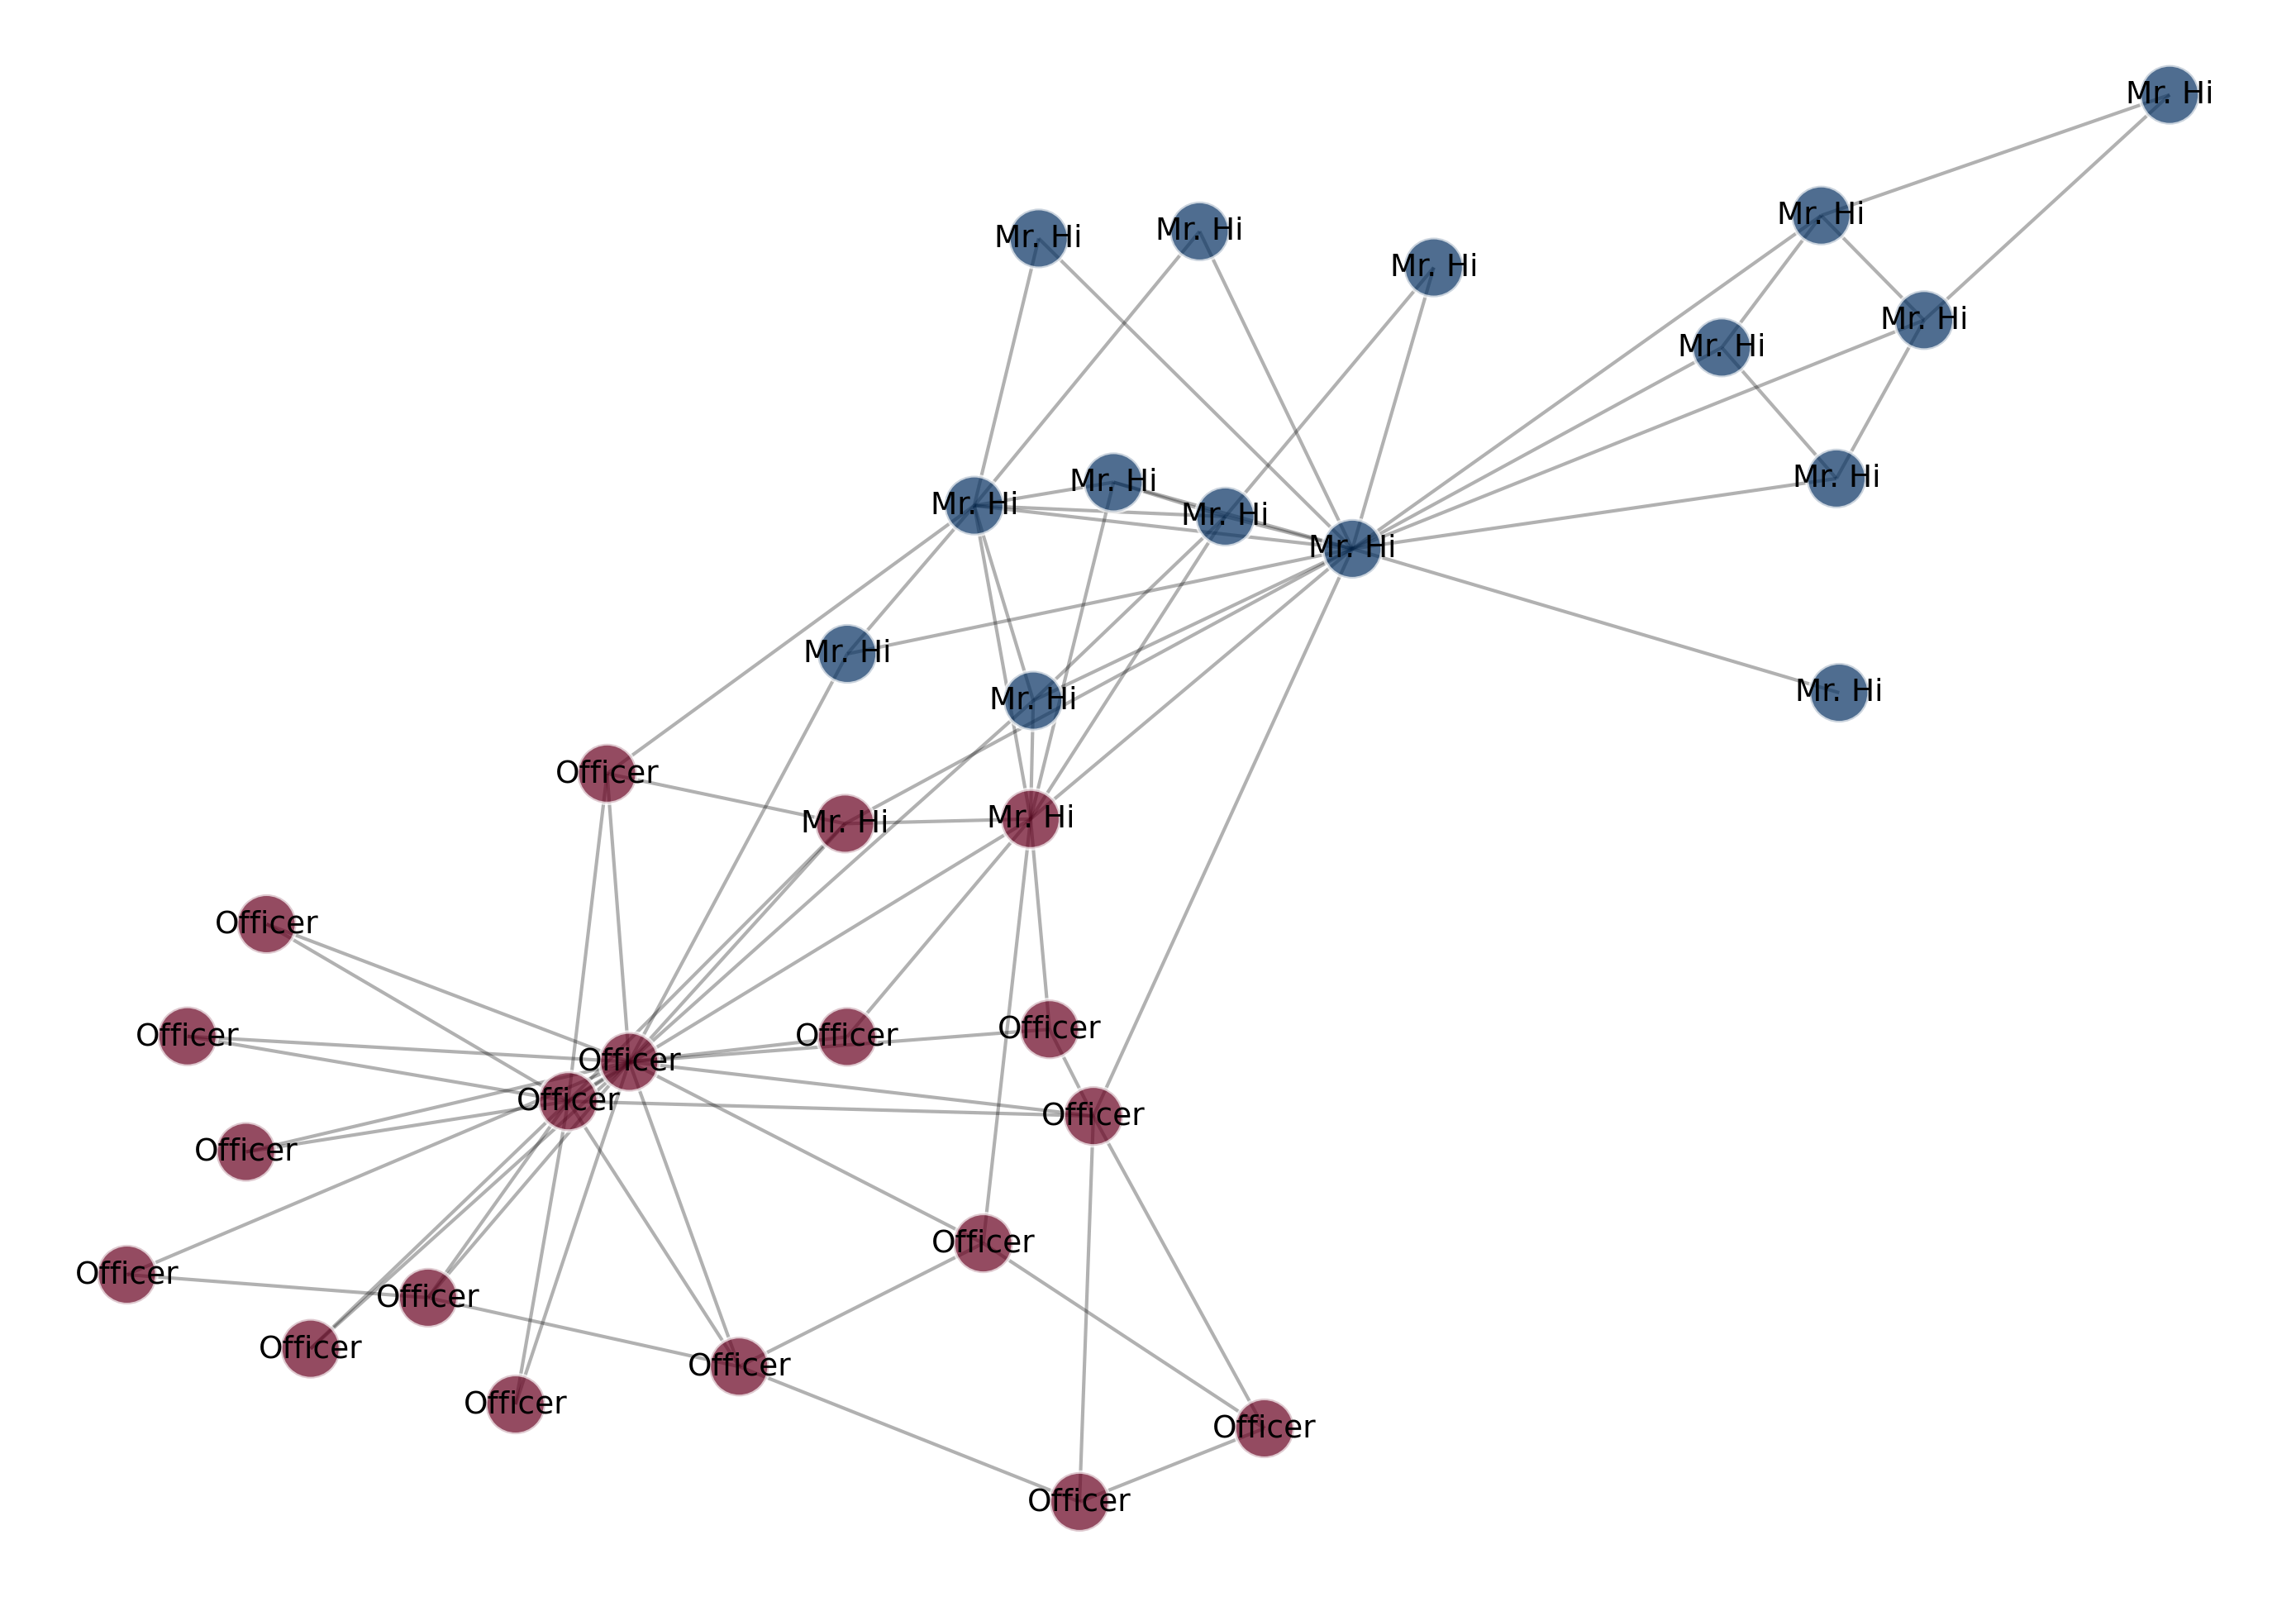

In [114]:
dpi = 300
h,w = 2480,3508
fig = plt.figure(figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.gca()


pos = spring_layout(G)

nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_nodes(
        G,
        pos,
        node_color=[G.nodes[node_id]['community'] for node_id in list(G)],
        edgecolors="white",
        alpha=0.7,
        cmap="RdBu_r"
)
nx.draw_networkx_labels(
                        G, 
                        pos, 
                        labels={ n_id:G.nodes[n_id]["club"] for n_id in G.nodes()}, 
                        font_size=9, 
                        font_color="black");
plt.axis("off")
plt.show()

## (EN)
## 3.3: Discuss the results obtained by the Newman/Girvan algorithm on the "Zachary's karate club"

Your Answer ?

## (FR)
## 3.3 Discuter les résultats obtenus par l'algorithme Newman/Girvan sur le graph du "Karaté club de Zachary"

Votre réponse ?

# (EN) 
# Exercice 4: Finding Community in retweet network

## The Russian Twitter Trolls Database In Neo4j

As part of the House Intelligence Committee investigation into how Russia may have influenced the 2016 US Election, Twitter released the screen names of almost 3000 Twitter accounts believed to be connected to Russia’s Internet Research Agency, a company known for operating social media troll accounts. Twitter immediately suspended these accounts, deleting their data from Twitter.com and the Twitter API.

A team at NBC News including **Ben Popken** and **EJ Fox** was able to reconstruct a dataset consisting of a subset of the deleted data for their investigation and using Neo4j were able to show how these troll accounts went on attack during key election moments. NBC News open-sourced the reconstructed dataset and released it as this Neo4j database.

NBC News has publicly released a database of deleted tweets from their investigation into how Russian Twitter Trolls may have influenced the 2016 US election. You can read about the results of NBC’s analysis in their stories [here](https://www.nbcnews.com/tech/social-media/now-available-more-200-000-deleted-russian-troll-tweets-n844731) and [here](https://www.nbcnews.com/tech/social-media/russian-trolls-went-attack-during-key-election-moments-n827176), but the focus of this post will be on how you can explore the data on your own, using open source data analysis tools. We’ll show how to get started with the data and hopefully inspire you to dig into the data yourself.

The dataset contains: 345K tweets, 41K users (in which 445 users have been identified as Russian trolls)

### Example of a troll account

This screenshot is the profile image of user **@LeroyLovesUSA**, one of the accounts Twitter has identified as being operated by the Internet Research Agency in Russia. Many accounts were intended to appear as normal everyday Americans just like this one.

<img src="../../images/russian-troll-twitter-fake-avatar.png" style="display:block;margin-left:auto;margin-right:auto;width:25%;"></img>

In this exercise you will learn to find what:

- Find influential Troll accounts?
- Find communities using community detection algorithms


## Neo4j Sandbox and Neo4j Browser
NBC News has released the data as a Neo4j Database and CSV files that can be used with your favorite data analysis tools. But the easiest way to get started with the data is by using [Neo4j Sandbox](https://neo4j.com/sandbox/). [Neo4j Sandbox](https://neo4j.com/sandbox/) allows you to spin up a private hosted instance of Neo4j pre-populated with interesting datasets.


### Nodes
Nodes can have one or more node labels to describe the "type" of the node.

* Tweet - The tweet
* User - A Twitter user
* Troll - An optional node label to identify users that are on the House list of Russian troll accounts
* Hashtag - Any hashtags used in the tweet
* Source - The Twitter application used to post the tweet.
* URL - A link embedded in a tweet

### Relationships
Relationships have a single relationship type.

* POSTED - Connects the tweet with the User who posted it
* MENTIONS - Connects any Users that are @-mentioned to the Tweet
* HAS_TAG - Connect a tweet to any Hashtag nodes included in the tweet
* POSTED_VIA - Connects a tweet to its Source application node
* RETWEETED - Connects a tweet that retweets another Tweet
* IN_REPLY_TO - Connects a tweet that is a reply to another Tweet

<img src="../../images/troll_datamodel.png" style="display:block;margin-left:auto;margin-right:auto;width:50%;"></img>


# (FR) 
# Exercice 4 : Trouver une communauté dans le réseau de retweet

## La base de données russe des Trolls Twitter dans Neo4j

Dans le cadre de l'enquête du Sénat américain sur la manière dont la Russie a pu influencer les élections américaines de 2016, Twitter a publié les noms d'écran de près de 3000 comptes Twitter qui seraient connectés à l'Internet Research Agency de Russie, une société connue pour exploiter des comptes de trolls sur les réseaux sociaux. Twitter a immédiatement suspendu ces comptes, supprimant leurs données de leur API.

Une équipe de NBC News comprenant **Ben Popken** et **EJ Fox** a pu reconstruire un ensemble de données composé d'un sous-ensemble des données supprimées pour leur enquête et en utilisant Neo4j, ils ont pu montrer comment ces comptes de trolls ont été attaqués pendant les moments clés des élections. NBC News a ouvert l'ensemble des données reconstruites et l'a publié sous le nom de base de données Neo4j.

NBC News a publié publiquement une base de données de tweets supprimés de leur enquête sur la façon dont les Trolls russes de Twitter ont pu influencer les élections américaines de 2016. Vous pouvez lire les résultats de l'analyse de NBC dans leurs histoires [ici](https://www.nbcnews.com/tech/social-media/now-available-more-200-000-deleted-russian-troll-tweets-n844731) et [ici](https://www.nbcnews.com/tech/social-media/russian-trolls-went-attack-during-key- Election-moments-n827176), mais cet article se concentrera sur la façon dont vous pouvez explorer les données par vous-même, à l'aide d'outils d'analyse de données open source. Nous vous montrerons comment démarrer avec les données et, espérons-le, vous inspirerons à creuser vous-même les données.

L'ensemble de données contient : 345K tweets, 41K utilisateurs (dont 445 utilisateurs ont été identifiés comme des trolls russes)

### Exemple de compte troll

Cette capture d'écran est l'image de profil de l'utilisateur **@LeroyLovesUSA**, l'un des comptes identifiés par Twitter comme étant exploité par l'Agence de recherche Internet en Russie. De nombreux comptes étaient destinés à apparaître comme des Américains ordinaires comme celui-ci.

<img src="../../images/russian-troll-twitter-fake-avatar.png" style="display:block;margin-left:auto;margin-right:auto;width:25%;" ></img>

Dans l'exercice, vous apprendrez à trouver ce que :

- Trouver des comptes Troll influents ?
- Trouver des communautés à l'aide d'algorithmes de détection de communauté


## Neo4j Sandbox et navigateur Neo4j
NBC News a publié les données sous forme de base de données Neo4j et de fichiers CSV pouvant être utilisée avec vos outils d'analyse de données préférés. Mais le moyen le plus simple de commencer avec les données est d'utiliser [Neo4j Sandbox] (https://neo4j.com/sandbox/). [Neo4j Sandbox](https://neo4j.com/sandbox/) vous permet de créer une instance hébergée privée de Neo4j préremplie avec des ensembles de données intéressants.

### noeuds
Les noeuds peuvent avoir une ou plusieurs étiquettes pour décrire le "type" du noeud.

* Tweet - Le Tweet
* Utilisateur - Un utilisateur de Twitter
* Troll - Une étiquette de nœud facultative pour identifier les utilisateurs qui figurent sur la liste House des comptes de trolls russes
* Hashtag - Tous les hashtags utilisés dans le tweet
* Source - L'application Twitter utilisée pour publier le tweet
* URL - Un lien intégré dans un tweet

### Des relations
Les relations ont un seul type de relation.

* PUBLIÉ - Connecte le Tweet à l'Utilisateur qui l'a posté.
* MENTIONS - Connecte tous les utilisateurs qui sont @-mentionnés au Tweet.
* HAS_TAG - Connectez un Tweet à n'importe quel nœud Hashtag inclus dans le tweet.
* POSTED_VIA - Connecte un Tweet à son nœud d'application Source.
* RETWEETED - Connecte un Tweet qui retweete un autre Tweet.
* IN_REPLY_TO - Connecte un Tweet qui est une réponse à un autre Tweet.

<img src="../../images/troll_datamodel.png" style="display:block;margin-left:auto;margin-right:auto;width:50%;"></img>

## (EN)
## Connect to the NEO4J database

## (FR)
## Connection à la base de données NEO4J

In [35]:
from neo4j import GraphDatabase, basic_auth

def query_neo4j(driver, cypher_query, database="neo4j"):
    with driver.session(database=database) as session:
        results = session.read_transaction(
            lambda tx: tx.run(cypher_query).data())
        return results

In [36]:
#
# Replace the XXX with your own connection credentials
#

driver = GraphDatabase.driver(
    "bolt://3.82.242.250:7687",
    auth=basic_auth("neo4j", "architecture-organ-sweepers"))

## (EN)
## What are the most commonly used hashtags by the Trolls?

## (FR)
## Quels sont les hashtags les plus couramment utilisés par les Trolls ?

In [37]:
cypher_query = '''
MATCH (t:Troll)-[:POSTED]->(tw:Tweet)-[:HAS_TAG]->(ht:Hashtag)
RETURN ht.tag, COUNT(tw) AS num
ORDER BY num DESC
'''

result = query_neo4j(driver, cypher_query)

In [38]:
trollsHashtags = pd.DataFrame(result)

In [40]:
trollsHashtags.head(20)

ht.tag   num
0                     politics  3442
1                         maga  2286
2                         tcot  2048
3                        trump  1922
4                         news  1757
5                        pjnet   968
6                 neverhillary   967
7                    trump2016   801
8            merkelmussbleiben   796
9                 trumppence16   744
10        rejecteddebatetopics   620
11               wakeupamerica   617
12                     hillary   609
13              hillaryclinton   582
14                  trumptrain   555
15            blacklivesmatter   542
16                        ccot   531
17              crookedhillary   524
18  betteralternativetodebates   513
19                       obama   503

## (EN)
## What Troll accounts have the most followers?

## (FR)
## Quels comptes Troll ont le plus de followers ?

In [41]:
cypher_query = '''
MATCH (u:Troll) 
WHERE EXISTS(u.followers_count)
RETURN u.screen_name AS screen_name, u.followers_count AS followers
ORDER BY followers DESC
'''

result = query_neo4j(driver, cypher_query)

In [42]:
trollsFollowers = pd.DataFrame(result)

In [43]:
trollsFollowers.head(10)

screen_name  followers
0    MaxDementiev      98412
1   KadirovRussia      94773
2     Jenn_Abrams      61609
3     TodayNYCity      60897
4    LavrovMuesli      47080
5    coldwar20_ru      44470
6      Politweecs      32846
7  WashingtOnline      31729
8     PigeonToday      29524
9    NewOrleansON      27745

## (EN)
## Trolls Dynamics over time 

## (FR)
## Dynamique des trolls au fil du temps

In [44]:
cypher_query = '''
MATCH (t:Tweet)<-[:POSTED]-(u:Troll) WHERE not(t.created_str='')
WITH apoc.date.parse(t.created_str, "ms", "yyyy-MM-dd HH:mm:ss") as ms
RETURN date(datetime({epochmillis:ms})).year as year, date(datetime({epochmillis:ms})).day as day, date(datetime({epochmillis:ms})).month as month, COUNT(*) as num ORDER BY year, month, day
'''

result = query_neo4j(driver, cypher_query)

In [45]:
timeline = pd.DataFrame(result)
timeline['date'] = pd.to_datetime(timeline[['year', 'month', 'day']])
timeline = timeline.set_index('date')

In [46]:
timeline

year  day  month  num
date                             
2014-07-14  2014   14      7    1
2014-07-17  2014   17      7    1
2014-07-20  2014   20      7    2
2014-07-22  2014   22      7    3
2014-07-23  2014   23      7    1
...          ...  ...    ...  ...
2017-09-10  2017   10      9    7
2017-09-16  2017   16      9    6
2017-09-19  2017   19      9    1
2017-09-24  2017   24      9    1
2017-09-26  2017   26      9    3

[930 rows x 4 columns]

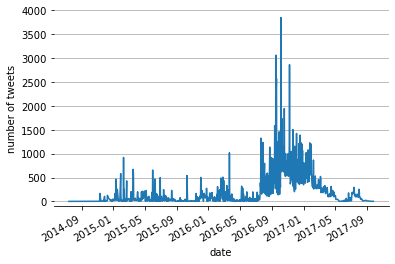

In [47]:
fig, ax = plt.subplots()

timeline["num"].plot(ax=ax)

ax.set_ylim(-100, 4000)
ax.yaxis.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_ylabel("number of tweets");

## (EN)
## Inferred relationships — what Trolls are retweeting other Trolls?

## (FR)
## Quels Trolls retweetent d'autres Trolls ? 

In [48]:
cypher_query = '''
MATCH (r1:Troll)-[:POSTED]->(:Tweet)<-[:RETWEETED]-(:Tweet)<-[:POSTED]-(r2:Troll)
RETURN id(r2) as source, 
    id(r1) as target, 
    r1.screen_name as source_screen_name, 
    r1.name as source_name,
    r2.screen_name as target_screen_name,
    r2.name as target_name,
    COUNT(*) as weight
'''

edges = query_neo4j(driver, cypher_query)

## (EN)
## Build the retweet network with networkx   

## (FR)
## Sauvegarde le réseau de retweet avec networkx

In [49]:
G = nx.Graph()
for edge in edges:
    if edge["source"] != edge["target"]:
        G.add_node(edge["target"], name=edge["target_screen_name"])
        G.add_node(edge["source"], name=edge["source_screen_name"])
        G.add_edge(edge["source"], edge["target"], weight=edge["weight"])

In [50]:
G.nodes(data=True)

NodeDataView({42: {'name': 'BrianTheLifter'}, 9: {'name': 'BlackToLive'}, 26: {'name': 'JmsCoxxx'}, 10: {'name': 'mr_clampin'}, 189: {'name': 'DickyIrwin'}, 190: {'name': 'RH0lbr00k'}, 11: {'name': 'USA_Gunslinger'}, 217: {'name': 'rightnpr'}, 44: {'name': 'RealTEN_GOP'}, 41: {'name': 'RH0lbr00k'}, 43: {'name': 'BLMSoldier'}, 15: {'name': 'Crystal1Johnson'}, 16: {'name': 'Crystal1Johnson'}, 233: {'name': 'hollandpatrickk'}, 17: {'name': 'c__wells'}, 244: {'name': 'c__wells'}, 130: {'name': 'c__wells'}, 167: {'name': 'c__wells'}, 180: {'name': 'c__wells'}, 201: {'name': 'LazyKStafford'}, 21: {'name': 'TEN_GOP'}, 25: {'name': 'c__wells'}, 403: {'name': 'c__wells'}, 199: {'name': 'GiselleEvns'}, 47: {'name': 'c__wells'}, 228: {'name': 'c__wells'}, 74: {'name': 'evewebster373'}, 139: {'name': 'evewebster373'}, 61: {'name': 'c__wells'}, 202: {'name': 'c__wells'}, 95: {'name': 'c__wells'}, 82: {'name': 'c__wells'}, 155: {'name': 'c__wells'}, 170: {'name': 'hollandpatrickk'}, 271: {'name': 'p

## (EN)
## Find the communities and compute the pagerank of each troll by using the neo4j API

## (FR)
## Trouvez les communautés et calculez le pagerank de chaque troll en utilisant l'API neo4j

In [51]:
cypher_query = '''
CALL gds.pageRank.stream({
    nodeQuery:"MATCH (t:Troll) RETURN id(t) AS id", 
    relationshipQuery:"MATCH (r1:Troll)-[:POSTED]->(:Tweet)<-[:RETWEETED]-(:Tweet)<-[:POSTED]-(r2:Troll) RETURN id(r2) as source, id(r1) as target"
})
YIELD nodeId, score
RETURN nodeId, gds.util.asNode(nodeId).screen_name AS name, score ORDER BY score DESC, name ASC
'''

pr = query_neo4j(driver, cypher_query)

In [11]:
pr

[{'nodeId': 44, 'name': 'TEN_GOP', 'score': 10.4348405335229},
 {'nodeId': 191, 'name': 'TheFoundingSon', 'score': 8.227596890927316},
 {'nodeId': 188, 'name': 'GiselleEvns', 'score': 6.499728904582508},
 {'nodeId': 210, 'name': 'tpartynews', 'score': 6.359775098908643},
 {'nodeId': 192, 'name': 'ChrixMorgan', 'score': 4.245442262044922},
 {'nodeId': 268, 'name': 'NotRitaHart', 'score': 3.9580074279341675},
 {'nodeId': 42, 'name': 'BlackToLive', 'score': 3.884966222309924},
 {'nodeId': 189, 'name': 'DanaGeezus', 'score': 3.3215578694249634},
 {'nodeId': 206, 'name': 'gloed_up', 'score': 2.7326550591063565},
 {'nodeId': 36, 'name': 'DaileyJadon', 'score': 2.1814067559870436},
 {'nodeId': 80, 'name': 'Pamela_Moore13', 'score': 2.0245235987539507},
 {'nodeId': 295, 'name': 'RealTEN_GOP', 'score': 1.8357721401752363},
 {'nodeId': 296, 'name': 'March_for_Trump', 'score': 1.8201145216702357},
 {'nodeId': 274, 'name': 'DominicValent', 'score': 1.7748041334061446},
 {'nodeId': 89, 'name': 'Mel

In [52]:
cypher_query = '''
CALL gds.louvain.stream({
  nodeQuery:"MATCH (t:Troll) RETURN id(t) AS id", 
  relationshipQuery:"MATCH (r1:Troll)-[:POSTED]->(:Tweet)<-[:RETWEETED]-(:Tweet)<-[:POSTED]-(r2:Troll) RETURN id(r2) as source, id(r1) as target, count(*) as weight"
})
YIELD nodeId, communityId AS Community
RETURN nodeId, gds.util.asNode(nodeId).screen_name AS Name, Community
'''

community = query_neo4j(driver, cypher_query)

In [53]:
community

[{'nodeId': 0, 'Name': 'SCOTTGOHARD', 'Community': 0},
 {'nodeId': 1, 'Name': 'Beckster319', 'Community': 1},
 {'nodeId': 2, 'Name': 'skatewake1994', 'Community': 2},
 {'nodeId': 3, 'Name': 'KadirovRussia', 'Community': 3},
 {'nodeId': 4, 'Name': 'MargoSavazh', 'Community': 4},
 {'nodeId': 5, 'Name': 'darknally', 'Community': 5},
 {'nodeId': 6, 'Name': 'lagonehoe', 'Community': 6},
 {'nodeId': 7, 'Name': 'YouJustCtrlC', 'Community': 7},
 {'nodeId': 8, 'Name': 'MrMoraan', 'Community': 8},
 {'nodeId': 9, 'Name': 'NoJonathonNo', 'Community': 42},
 {'nodeId': 10, 'Name': 'CharlesJHarper', 'Community': 189},
 {'nodeId': 11, 'Name': 'PrettyLaraPlace', 'Community': 296},
 {'nodeId': 12, 'Name': 'BigBoyJasiah', 'Community': 12},
 {'nodeId': 13, 'Name': 'Jery_RobertsYo', 'Community': 13},
 {'nodeId': 14, 'Name': 'LILJordamn', 'Community': 14},
 {'nodeId': 15, 'Name': 'PaulineTT', 'Community': 43},
 {'nodeId': 16, 'Name': 'RamonasNails', 'Community': 43},
 {'nodeId': 17, 'Name': 'JeffreyKahunas'

## (EN)
## Find the communities and compute the pagerank of each troll by using networkx

Use the [Louvain](https://en.wikipedia.org/wiki/Louvain_method) algorithm definied in the [scikit-network](https://scikit-network.readthedocs.io/en/latest/tutorials/clustering/louvain.html) library to calculate the different communities in the retweet network. 

## (FR)
## Trouvez les communautés et calculez le pagerank de chaque troll en utilisant networkx

Utilisez l'algorithme de [Louvain](https://fr.wikipedia.org/wiki/M%C3%A9thode_de_Louvain) et la librairie [scikit-network](https://scikit-network.readthedocs.io/en/latest/tutorials/clustering/louvain.html) pour calculer les différentes communautés contrenue dans le reseau de retweet.  

In [54]:
from sknetwork.clustering import Louvain
from sknetwork.ranking import PageRank

# 1. extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
S = G.subgraph(largest_cc).copy()

### BEGIN SOLUTION
node_list = list(S.nodes())
adjacency = nx.to_scipy_sparse_matrix(S, nodelist=node_list, format='csr')

louvain = Louvain()
communities = louvain.fit_transform(adjacency)
pr = nx.pagerank(S)
### END SOLUTION

# Store the result in the graph
results = []
for v in range(len(node_list)):
    results.append([node_list[v], communities[v], pr[node_list[v]], S.nodes[node_list[v]]["name"]])
    S.nodes[node_list[v]]["community"] = communities[v]
    S.nodes[node_list[v]]["pagerank"] = pr[node_list[v]]
    
df = pd.DataFrame(results, columns=["node_id", "community_id", "pagerank", "name"])
df = df.sort_values("pagerank", ascending=False)
df

node_id  community_id  pagerank             name
8         44             2  0.069115      RealTEN_GOP
43       188             1  0.038057       DickyIrwin
76       210             2  0.027725      RealTEN_GOP
60        36             1  0.020860    LazyKStafford
25       228             0  0.020553         c__wells
..       ...           ...       ...              ...
136      272             1  0.001296   MelvinSRoberts
79       203             0  0.001290  GarrettSimpson_
138      327             1  0.001289    DominicValent
126       78             0  0.001285  hollandpatrickk
121      416             1  0.001264      GiselleEvns

[141 rows x 4 columns]

## (EN)
## Plot the retweet network with the community color coded and the node size proportinal to the pagerank of that node

## (FR)
## Trouvez les communautés et calculez le pagerank de chaque troll en utilisant networkx

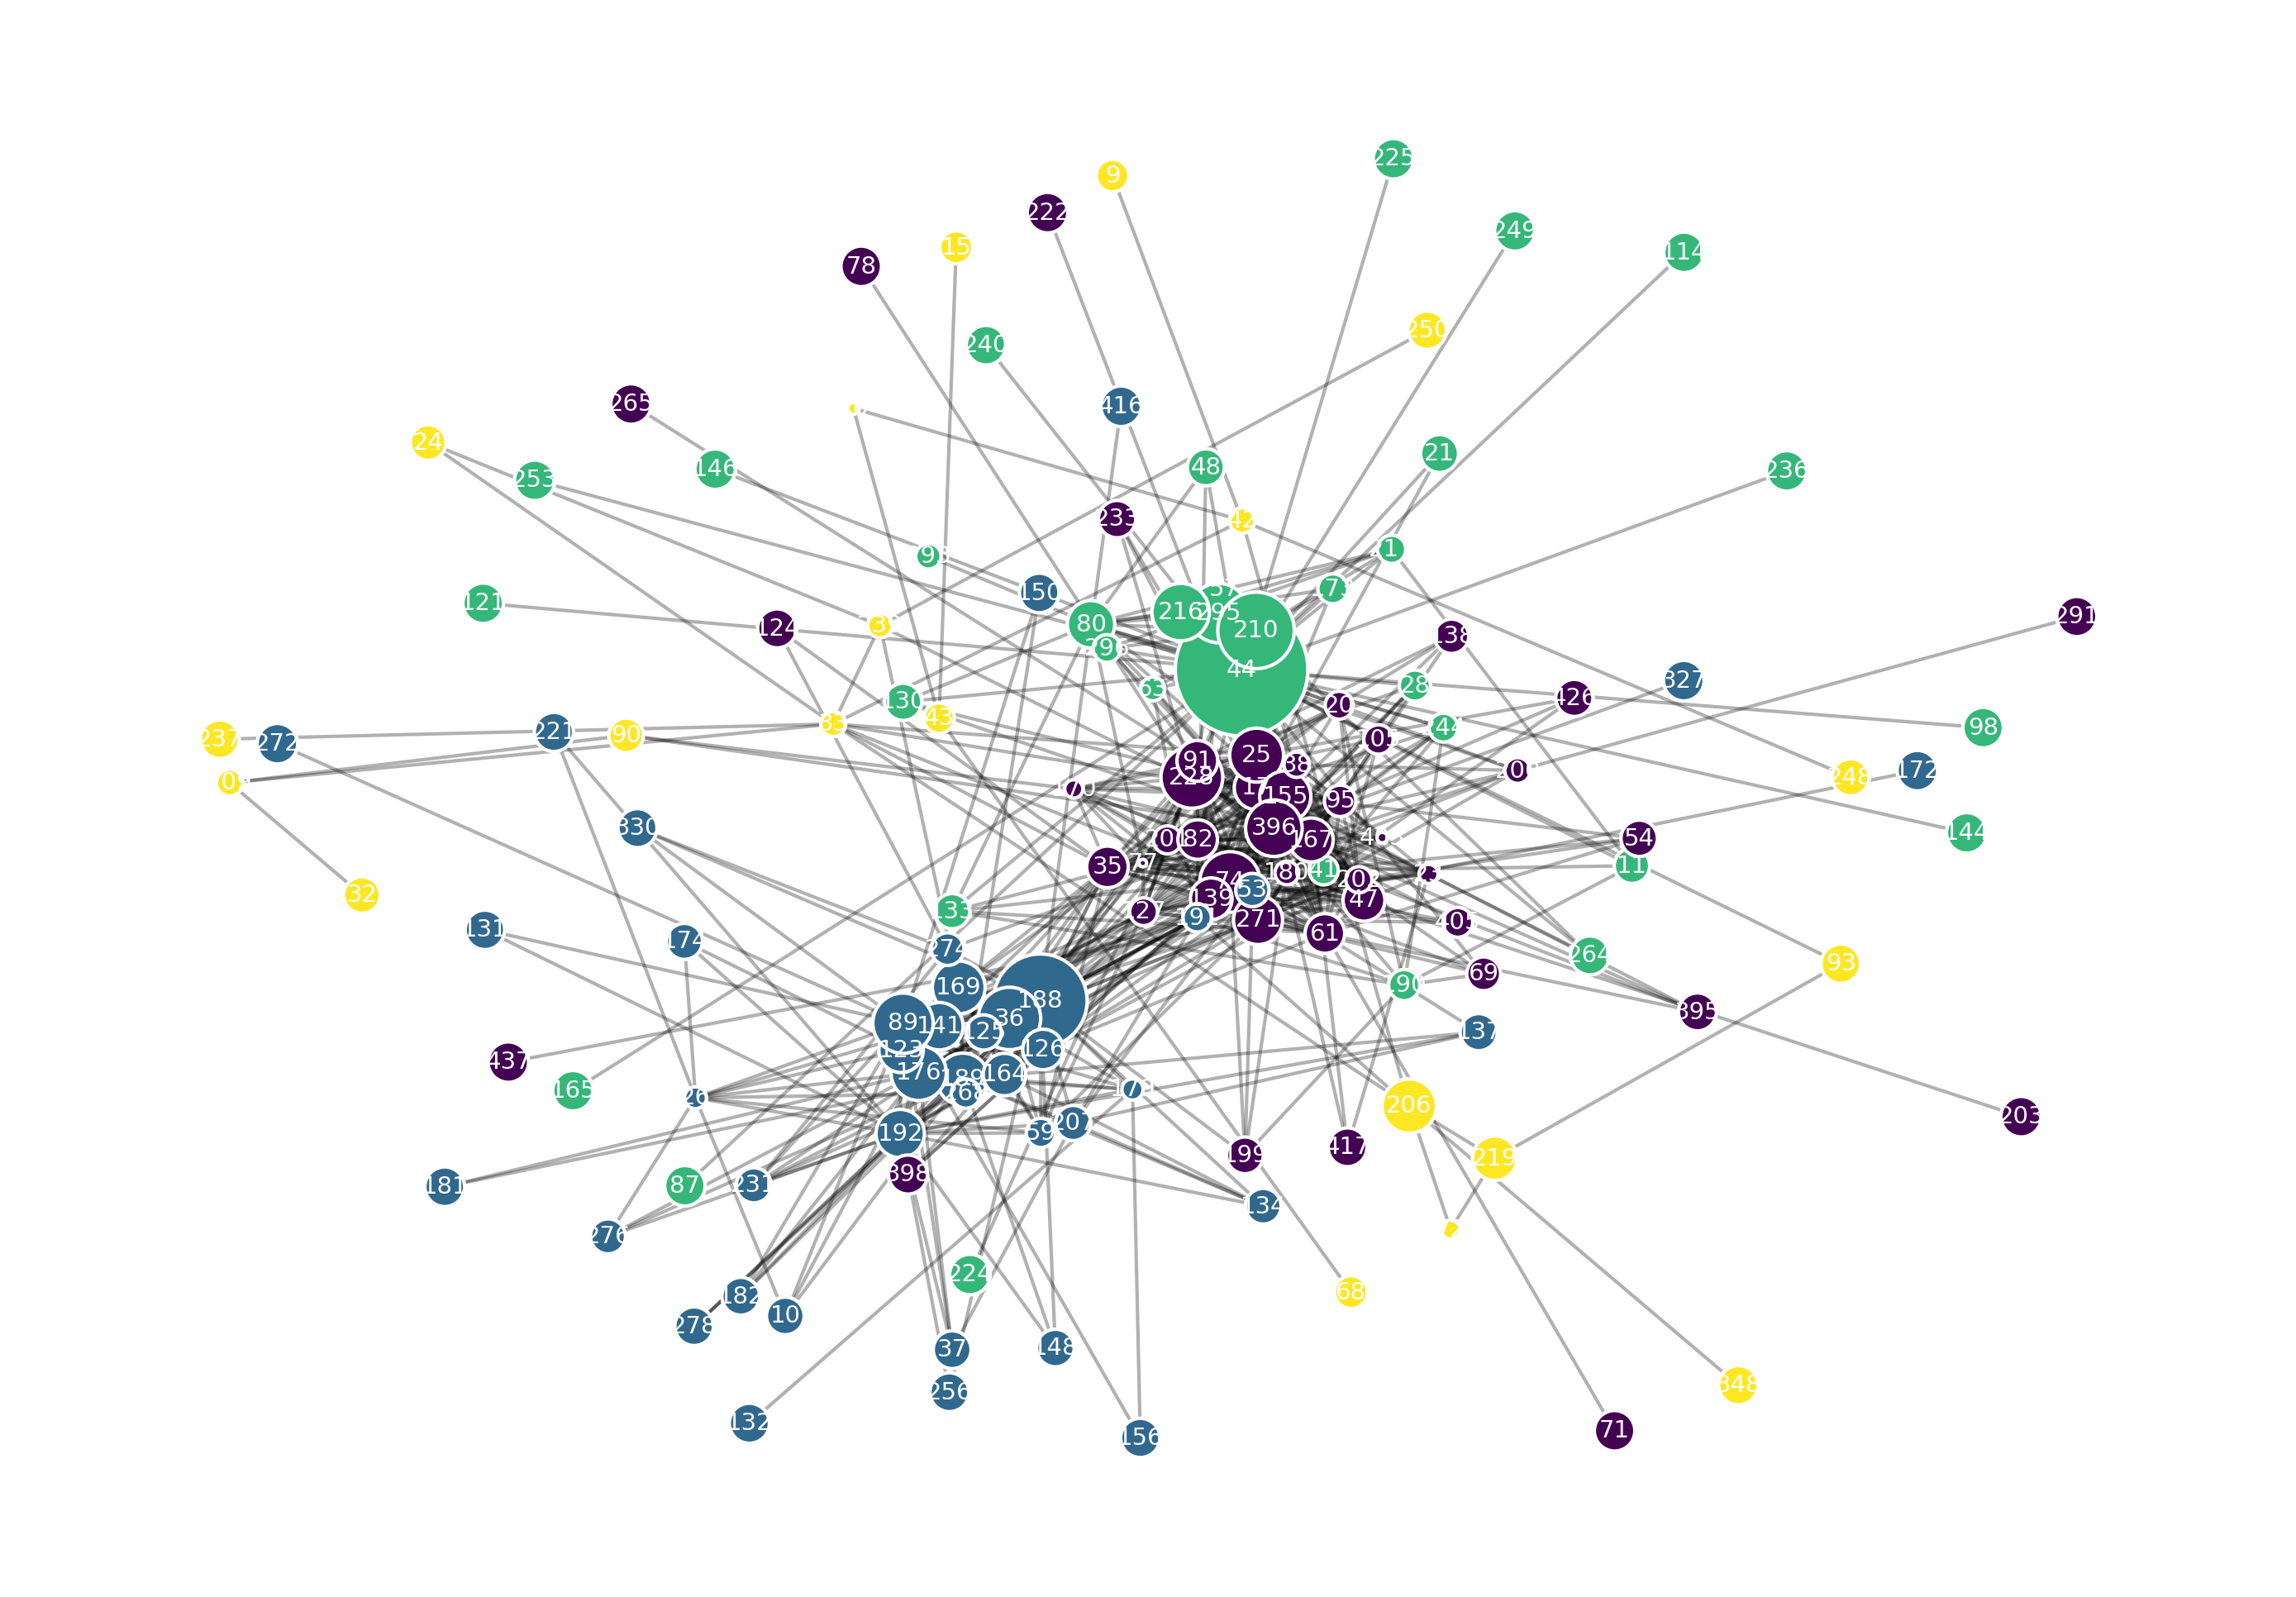

In [55]:
dpi = 300
h,w = 2480,3508

pos = nx.spring_layout(S, weight="weight",k=0.25, iterations=20)

### BEGIN SOLUTION
node_pagerank = nx.get_node_attributes(S,'pagerank')
community = nx.get_node_attributes(S,'community')


mean_pr = np.mean([S.nodes[node_id]['pagerank'] for node_id in S.nodes()])
std_pr = np.std([S.nodes[node_id]['pagerank'] for node_id in S.nodes()])
node_size = [200*abs(S.nodes[node_id]['pagerank'] - mean_pr) /std_pr for node_id in list(S)]
### END SOLUTION

fig = plt.figure(figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.gca()


nx.draw_networkx_edges(S, pos, alpha=0.3)
nx.draw_networkx_nodes(
        S,
        pos,
        node_color=[S.nodes[node_id]['community'] for node_id in list(S)],
        node_size=node_size,
        edgecolors="white"
)
nx.draw_networkx_labels(S, pos, font_size=7, font_color="white");
plt.axis("off")
plt.show()

## (EN)
## By reading tweets originating from different communities, could you guess what is the main difference between them

## (FR)
## En lisant des tweets provenant de différentes communautés, pourriez-vous deviner quelles sont les principales différence entre les communautés

In [92]:
S.nodes[44]

{'name': 'RealTEN_GOP', 'community': 2, 'pagerank': 0.06872774897096531}

In [93]:
cypher_query = '''
MATCH (r1:Troll)-[:POSTED]->(tw:Tweet)-[:HAS_TAG]->(ht:Hashtag)
WHERE r1.screen_name = 'RealTEN_GOP'
RETURN ht.tag AS tag, COUNT(tw) AS num ORDER BY num DESC
'''
hashtag = query_neo4j(driver, cypher_query)

In [94]:
hashtag

[{'tag': 'mustbebanned', 'num': 5},
 {'tag': 'igetdepressedwhen', 'num': 4},
 {'tag': 'imwithher', 'num': 4},
 {'tag': 'rejecteddebatetopics', 'num': 3},
 {'tag': 'debate', 'num': 3},
 {'tag': 'ihavearighttoknow', 'num': 2},
 {'tag': 'betteralternativetodebates', 'num': 2},
 {'tag': 'istartcryingwhen', 'num': 2},
 {'tag': 'trumpsfavoriteheadline', 'num': 2},
 {'tag': 'reasonshumanswillgoextinct', 'num': 2},
 {'tag': 'electiondayin5words', 'num': 2},
 {'tag': 'debates', 'num': 1},
 {'tag': 'hillarysbodydouble', 'num': 1},
 {'tag': 'hillaryshealth', 'num': 1},
 {'tag': 'famouscreatures', 'num': 1},
 {'tag': 'nbcnewsforum', 'num': 1},
 {'tag': 'veterans', 'num': 1},
 {'tag': 'thingshillarygoogles', 'num': 1},
 {'tag': 'meangirlsrules', 'num': 1},
 {'tag': 'ifthemediariggedtheelection', 'num': 1},
 {'tag': 'timetravelerproblems', 'num': 1},
 {'tag': 'joynews', 'num': 1},
 {'tag': 'celebrityendorsementenvy', 'num': 1},
 {'tag': 'hillary2016', 'num': 1},
 {'tag': 'hillyes', 'num': 1},
 {'tag

In [ ]:
cypher_query = '''
MATCH (r1:Troll)-[:POSTED]->(t:Tweet)
WHERE r1.screen_name = 'RealTEN_GOP'
RETURN t.text LIMIT 20
'''

tweets = query_neo4j(driver, cypher_query)

In [88]:
tweets

[{'t.text': 'RT @TEN_GOP: WATCH: During #DemConvention protests black teen plays national anthem for police to show support for their service! https://t…'},
 {'t.text': 'I want EVERY African-American to watch this leaked video &amp; understand how arrogant Hillary is! https://t.co/b8n2W2Ks0o'},
 {'t.text': 'RT @TEN_GOP: American blacks are tired of 30 years of broken promises... \nThe clear choice is Donald Trump.\n#BasementDwellers https://t.co/…'},
 {'t.text': 'RT @TEN_GOP: Obama celebrating\n#InternationalFriendshipDay👇 https://t.co/knl9ApbBPb'},
 {'t.text': 'African Americans under President Obama. https://t.co/tBVIpjUnGG'},
 {'t.text': '.@newtgingrich: "For [@HillaryClinton] to say \'words matter\' is bizarre. She\'s done nothing all year but lie." https://t.co/U1x8KrRJCj'},
 {'t.text': "Wonder why media covers Trump unfairly? \nHere's the reason..\n#NeverHillary https://t.co/STvSzqhPc4"},
 {'t.text': 'More Health Concerns: Exhausted Hillary Is Taking Weekends Off\n#HillarysHealth